# Gaussian Diagnostics

Experiments to demonstrate Gaussian assumption used in `cubBayesLattice`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/gaussian_diagnostics_demo.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin as fminsearch
from numpy import prod, sin, cos, pi
from scipy.stats import norm as gaussnorm
from matplotlib import cm

In [2]:
from qmcpy.integrand import Keister
from qmcpy.discrete_distribution.lattice import Lattice

In [3]:
# print(plt.style.available)
# plt.style.use('./presentation.mplstyle')  # use custom settings
plt.style.use('seaborn-poster')

# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'lines.linewidth': 2})
# plt.rcParams.update({'lines.markersize': 6})

Let us define the objective function. 
(`cubBayesLattice`) finds optimal parameters by minimizing the objective function

In [4]:
def ObjectiveFunction(theta, order, xun, ftilde):
    tol = 100 * np.finfo(float).eps
    n = len(ftilde)
    arbMean = True
    Lambda = kernel2(theta, order, xun)

    # compute RKHSnorm
    # temp = abs(ftilde(Lambda  != 0).^ 2)./ (Lambda(Lambda != 0))
    temp = abs(ftilde[Lambda > tol] ** 2) / (Lambda[Lambda > tol])

    # compute loss: MLE
    if arbMean == True:
        RKHSnorm = sum(temp[1:]) / n
        temp_1 = sum(temp[1:])
    else:
        RKHSnorm = sum(temp) / n
        temp_1 = sum(temp)

    # ignore all zero eigenvalues
    loss1 = sum(np.log(Lambda[Lambda > tol])) / n
    loss2 = np.log(temp_1)
    loss = (loss1 + loss2)
    if np.any(np.imag(loss) != 0):
        # keyboard
        raise('error ! : loss value is complex')

    # print('L1 %1.3f L2 %1.3f L %1.3f r %1.3e theta %1.3e\n'.format(loss1, loss2, loss, order, theta))
    return loss, Lambda, RKHSnorm

Series approximation of the shift invariant kernel

In [5]:
def kernel2(theta, r, xun):
    n = xun.shape[0]
    m = np.arange(1, (n / 2))
    tilde_g_h1 = m ** (-r)
    tilde_g = np.hstack([0, tilde_g_h1, 0, tilde_g_h1[::-1]])
    g = np.fft.fft(tilde_g)
    temp_ = (theta / 2) * g[(xun * n).astype(int)]
    C1 = prod(1 + temp_, 1)
    # eigenvalues must be real : Symmetric pos definite Kernel
    vlambda = np.real(np.fft.fft(C1))
    return vlambda

Gaussian random function

In [6]:
def f_rand(xpts, rfun, a, b, c, seed):
    dim = xpts.shape[1]
    np.random.seed(seed)  # initialize random number generator for reproducability
    N1 = int(2 ** np.floor(16 / dim))
    Nall = N1 ** dim
    kvec = np.zeros([dim, Nall])  # initialize kvec
    kvec[0, 0:N1] = range(0, N1)  # first dimension
    Nd = N1
    for d in range(1, dim):
        Ndm1 = Nd
        Nd = Nd * N1
        kvec[0:d+1, 0:Nd] = np.vstack([
            np.tile(kvec[0:d, 0:Ndm1], (1, N1)),
            np.reshape(np.tile(np.arange(0, N1), (Ndm1, 1)), (1, Nd), order="F")
        ])

    kvec = kvec[:, 1: Nall]  # remove the zero wavenumber
    whZero = np.sum(kvec == 0, axis=0)
    abfac = a ** (dim - whZero) * b ** whZero
    kbar = np.prod(np.maximum(kvec, 1), axis=0)
    totfac = abfac / (kbar ** rfun)

    f_c = a * np.random.randn(1, Nall - 1) * totfac
    f_s = a * np.random.randn(1, Nall - 1) * totfac

    f_0 = c + (b ** dim) * np.random.randn()
    argx = np.matmul((2 * np.pi * xpts), kvec)
    f_c_ = f_c * np.cos(argx)
    f_s_ = f_s * np.sin(argx)
    fval = f_0 + np.sum(f_c_ + f_s_, axis=1)
    return fval

Periodization transforms

In [7]:
def doPeriodTx(x, integrand, ptransform):
    ptransform = ptransform.upper()
    if ptransform == 'BAKER':  # Baker's transform
        xp = 1 - 2 * abs(x - 1 / 2)
        w = 1
    elif ptransform == 'C0':  # C^0 transform
        xp = 3 * x ** 2 - 2 * x ** 3
        w = prod(6 * x * (1 - x), 1)
    elif ptransform == 'C1':  # C^1 transform
        xp = x ** 3 * (10 - 15 * x + 6 * x ** 2)
        w = prod(30 * x ** 2 * (1 - x) ** 2, 1)
    elif ptransform == 'C1SIN':  # Sidi C^1 transform
        xp = x - sin(2 * pi * x) / (2 * pi)
        w = prod(2 * sin(pi * x) ** 2, 1)
    elif ptransform == 'C2SIN':  # Sidi C^2 transform
        xp = (8 - 9 * cos(pi * x) + cos(3 * pi * x)) / 16  # psi3
        w = prod((9 * sin(pi * x) * pi - sin(3 * pi * x) * 3 * pi) / 16, 1)  # psi3_1
    elif ptransform == 'C3SIN':  # Sidi C^3 transform
        xp = (12 * pi * x - 8 * sin(2 * pi * x) + sin(4 * pi * x)) / (12 * pi)  # psi4
        w = prod((12 * pi - 8 * cos(2 * pi * x) * 2 * pi + sin(4 * pi * x) * 4 * pi) / (12 * pi), 1)  # psi4_1
    elif ptransform == 'NONE':
        xp = x
        w = 1
    else:
        raise (f"The {ptransform} periodization transform is not implemented")
    y = integrand(xp) * w
    return y

Utility function to draw qqplot or normplot

In [8]:
def create_quant_plot(type, vz_real, fName, dim, iii, r, rOpt, theta, thetaOpt):
    hFigNormplot, axFigNormplot = plt.subplots()

    n = len(vz_real)
    if type == 'normplot':
        axFigNormplot.normplot(vz_real)
    else:
        q = (np.arange(1, n + 1) - 1 / 2) / n
        stNorm = gaussnorm.ppf(q)  # norminv: quantiles of standard normal
        axFigNormplot.scatter(stNorm, sorted(vz_real), s=20)  # marker='.',
        axFigNormplot.plot([-3, 3], [-3, 3], marker='_', linewidth=4, color='red')
        axFigNormplot.set_xlabel('Standard Gaussian Quantiles')
        axFigNormplot.set_ylabel('Data Quantiles')

    if theta:
        plt_title = f'$d={dim}, n={n}, r={r:1.2f}, r_{{opt}}={rOpt:1.2f}, \\theta={theta:1.2f}, \\theta_{{opt}}={thetaOpt:1.2f}$'
        plt_filename = f'{fName}-QQPlot_n-{n}_d-{dim}_r-{r * 100}_th-{100 * theta}_case-{iii}.jpg'
    else:
        plt_title = f'$d={dim}, n={n}, r_{{opt}}={rOpt:1.2f}, \\theta_{{opt}}={thetaOpt:1.2f}$'
        plt_filename = f'{fName}-QQPlot_n-{n}_d-{dim}_case-{iii}.jpg'
        
    axFigNormplot.set_title(plt_title)
    hFigNormplot.savefig(plt_filename)

Utility function to plot the objective function and minimum

In [9]:
def create_surf_plot(fName, lnthth, lnordord, objfun, objobj, lnParamsOpt, r, theta, iii):
    figH, axH = plt.subplots(subplot_kw={"projection": "3d"})
    axH.view_init(40, 30)
    shandle = axH.plot_surface(lnthth, lnordord, objobj, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False, alpha=0.8)
    xt = np.array([.2, 0.4, 1, 3, 7])
    axH.set_xticks(np.log(xt))
    axH.set_xticklabels(xt.astype(str))
    yt = np.array([1.4, 1.6, 2, 2.6, 3.7])
    axH.set_yticks(np.log(yt - 1))
    axH.set_yticklabels(yt.astype(str))
    axH.set_xlabel('$\\theta$')
    axH.set_ylabel('$r$')    

    axH.scatter(lnParamsOpt[0], lnParamsOpt[1], objfun(lnParamsOpt) * 1.002,
                s=200, color='orange', marker='*', alpha=0.8)
    if theta:
        filename = f'{fName}-ObjFun_n-{npts}_d-{dim}_r-{r * 100}_th-{100 * theta}_case-{iii}.jpg'
    else:
        filename = f'{fName}-ObjFun_n-{npts}_d-{dim}_case-{iii}.jpg'                
    figH.savefig(filename)    

Minimum working example to demonstrate Gaussian diagnostics concept

In [10]:
def gaussian_diagnostics_engine(whEx, dim, npts, r, fpar, nReps, nPlots):
    whEx = whEx - 1
    fNames = ['ExpCos', 'Keister', 'rand']
    ptransforms = ['none', 'C1sin', 'none']
    fName = fNames[whEx]
    ptransform = ptransforms[whEx]

    rOptAll = [0]*nRep
    thOptAll = [0]*nRep

    # parameters for random function
    # seed = 202326
    if whEx == 2:
        rfun = r / 2
        f_mean = fpar[2]
        f_std_a = fpar[0]  # this is square root of the a in the talk
        f_std_b = fpar[1]  # this is square root of the b in the talk
        theta = (f_std_a / f_std_b) ** 2
    else:
        theta = None

    for iii in range(nReps):
        seed = np.random.randint(low=1, high=1e6)  # different each rep
        shift = np.random.rand(1, dim)

        distribution = Lattice(dimension=dim, order='linear')
        xpts, xlat = distribution.gen_samples(n_min=0, n_max=npts, warn=False, return_unrandomized=True)

        if fName == 'ExpCos':
            integrand = lambda x: np.exp(np.sum(np.cos(2 * np.pi * x), axis=1))
        elif fName == 'Keister':
            keister = Keister(Lattice(dimension=dim, order='linear'))
            integrand = lambda x: keister.f(x)
        elif fName == 'rand':
            integrand = lambda x: f_rand(x, rfun, f_std_a, f_std_b, f_mean, seed)
        else:
            print('Invalid function name')
            return

        y = doPeriodTx(xpts, integrand, ptransform)

        ftilde = np.fft.fft(y)  # fourier coefficients
        ftilde[0] = 0  # ftilde = \mV**H(\vf - m \vone), subtract mean
        if dim == 1:
            hFigIntegrand = plt.figure()
            plt.scatter(xpts, y, 10)
            plt.title(f'{fName}_n-{npts}_Tx-{ptransform}')
            hFigIntegrand.savefig(f'{fName}_n-{npts}_Tx-{ptransform}_rFun-{rfun:1.2f}.png')

        def objfun(lnParams):
            loss, Lambda, RKHSnorm = ObjectiveFunction(np.exp(lnParams[0]), 1 + np.exp(lnParams[1]), xlat, ftilde)
            return loss

        ## Plot the objective function
        lnthetarange = np.arange(-2, 2.2, 0.2)  # range of log(theta) for plotting
        lnorderrange = np.arange(-1, 1.1, 0.1)  # range of log(r) for plotting
        [lnthth, lnordord] = np.meshgrid(lnthetarange, lnorderrange)
        objobj = np.zeros(lnthth.shape)
        for ii in range(lnthth.shape[0]):
            for jj in range(lnthth.shape[1]):
                objobj[ii, jj] = objfun([lnthth[ii, jj], lnordord[ii, jj]])

        objMinAppx, which = objobj.min(), objobj.argmin()
        # [whichrow, whichcol] = ind2sub(lnthth.shape, which)
        [whichrow, whichcol] = np.unravel_index(which, lnthth.shape)
        lnthOptAppx = lnthth[whichrow, whichcol]
        thetaOptAppx = np.exp(lnthOptAppx)
        lnordOptAppx = lnordord[whichrow, whichcol]
        orderOptAppx = 1 + np.exp(lnordOptAppx)
        # print(objMinAppx)  # minimum objective function by brute force search

        ## Optimize the objective function
        result = fminsearch(objfun, x0=[lnthOptAppx, lnordOptAppx], xtol=1e-3, full_output=True, disp=False)
        lnParamsOpt, objMin = result[0], result[1]
        # print(objMin)  # minimum objective function by Nelder-Mead
        thetaOpt = np.exp(lnParamsOpt[0])
        rOpt = 1 + np.exp(lnParamsOpt[1])
        rOptAll[iii] = rOpt
        thOptAll[iii] = thetaOpt
        print(f'{iii}: thetaOptAppx={thetaOptAppx:7.5f}, rOptAppx={orderOptAppx:7.5f}, '
              f'objMinAppx={objMinAppx:7.5f}, objMin={objMin:7.5f}')

        if iii <= nPlots:
            create_surf_plot(fName, lnthth, lnordord, objfun, objobj, lnParamsOpt, r, theta, iii)

        vlambda = kernel2(thetaOpt, rOpt, xlat)
        s2 = sum(abs(ftilde[2:] ** 2) / vlambda[2:]) / (npts ** 2)
        vlambda = s2 * vlambda

        # apply transform
        # $\vZ = \frac 1n \mV \mLambda**{-\frac 12} \mV**H(\vf - m \vone)$
        # np.fft also includes 1/n division
        vz = np.fft.ifft(ftilde / np.sqrt(vlambda))
        vz_real = np.real(vz)  # vz must be real as intended by the transformation

        if iii <= nPlots:
            create_quant_plot('qqplot', vz_real, fName, dim, iii, r, rOpt, theta, thetaOpt)

        r_str = f"{r: 7.5f}" if type(r) == float else str(r)
        theta_str = f"{theta: 7.5f}" if type(theta) == float else str(theta)
        print(f'\t r = {r_str}, rOpt = {rOpt:7.5f}, theta = {theta_str}, thetaOpt = {thetaOpt:7.5f}\n')

    return [theta, rOptAll, thOptAll, fName]

## Example 1: Exponential of Cosine

0: thetaOptAppx=0.44933, rOptAppx=3.71828, objMinAppx=8.92769, objMin=8.84145
	 r = None, rOpt = 4.69789, theta = None, thetaOpt = 0.44466

1: thetaOptAppx=0.36788, rOptAppx=3.71828, objMinAppx=8.79435, objMin=8.67908
	 r = None, rOpt = 4.69789, theta = None, thetaOpt = 0.44466

1: thetaOptAppx=0.36788, rOptAppx=3.71828, objMinAppx=8.79435, objMin=8.67908
	 r = None, rOpt = 4.83290, theta = None, thetaOpt = 0.38381

2: thetaOptAppx=0.36788, rOptAppx=3.71828, objMinAppx=8.80734, objMin=8.67337
	 r = None, rOpt = 4.83290, theta = None, thetaOpt = 0.38381

2: thetaOptAppx=0.36788, rOptAppx=3.71828, objMinAppx=8.80734, objMin=8.67337
	 r = None, rOpt = 4.96411, theta = None, thetaOpt = 0.34342

3: thetaOptAppx=0.44933, rOptAppx=3.71828, objMinAppx=9.20900, objMin=9.17393
	 r = None, rOpt = 4.34829, theta = None, thetaOpt = 0.49325

4: thetaOptAppx=0.44933, rOptAppx=3.71828, objMinAppx=9.19732, objMin=9.16436
	 r = None, rOpt = 4.32391, theta = None, thetaOpt = 0.49356

	 r = None, rOpt = 4

Text(0.5, 1.0, '$d = 3, n = 64$')

Text(0.5, 0, 'Inferred $r$')

Text(0, 0.5, 'Inferred $\\theta$')

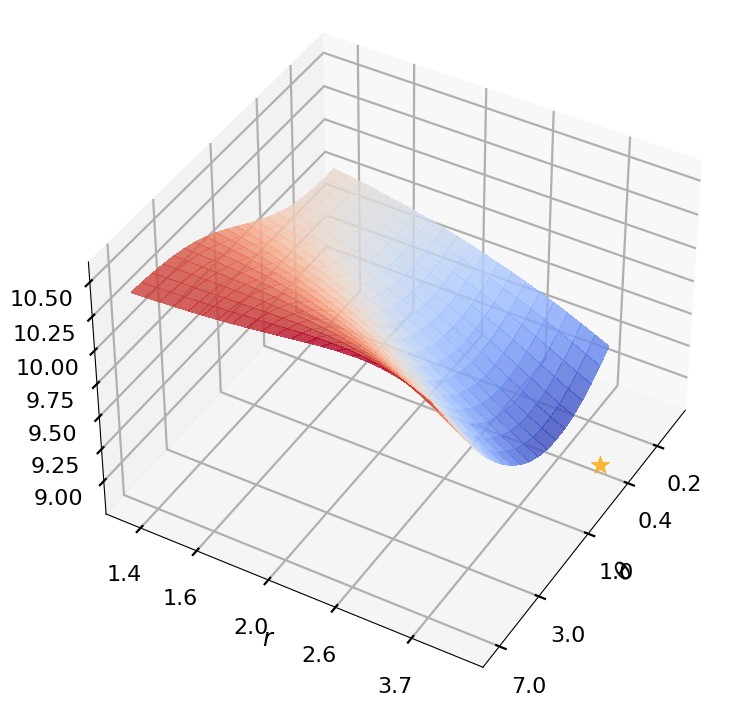

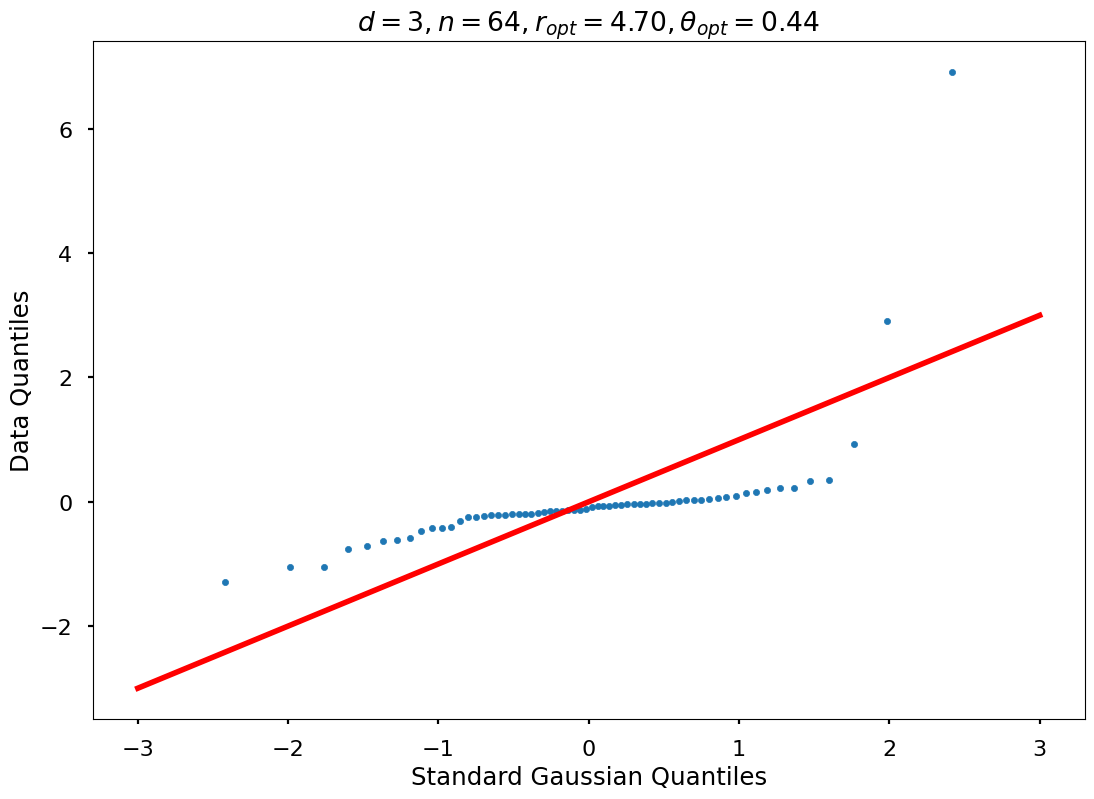

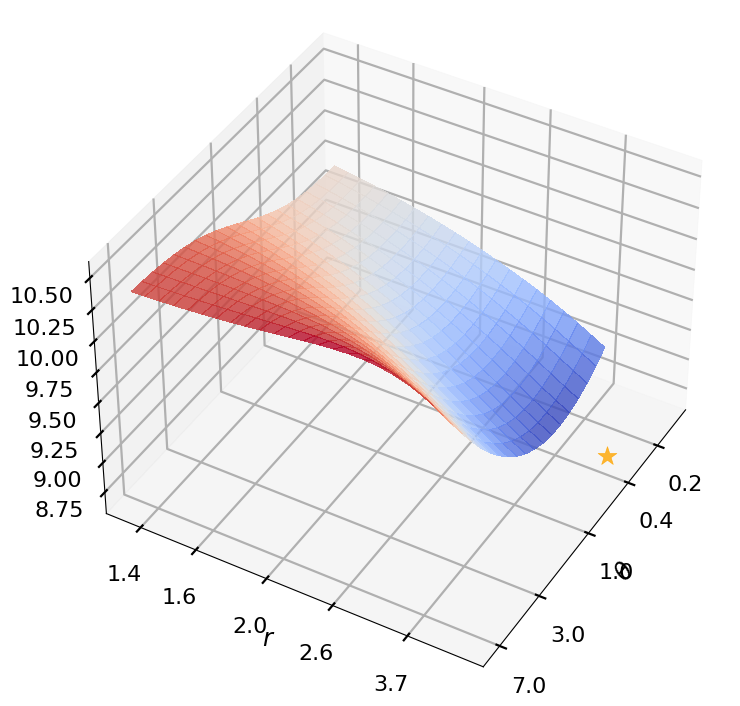

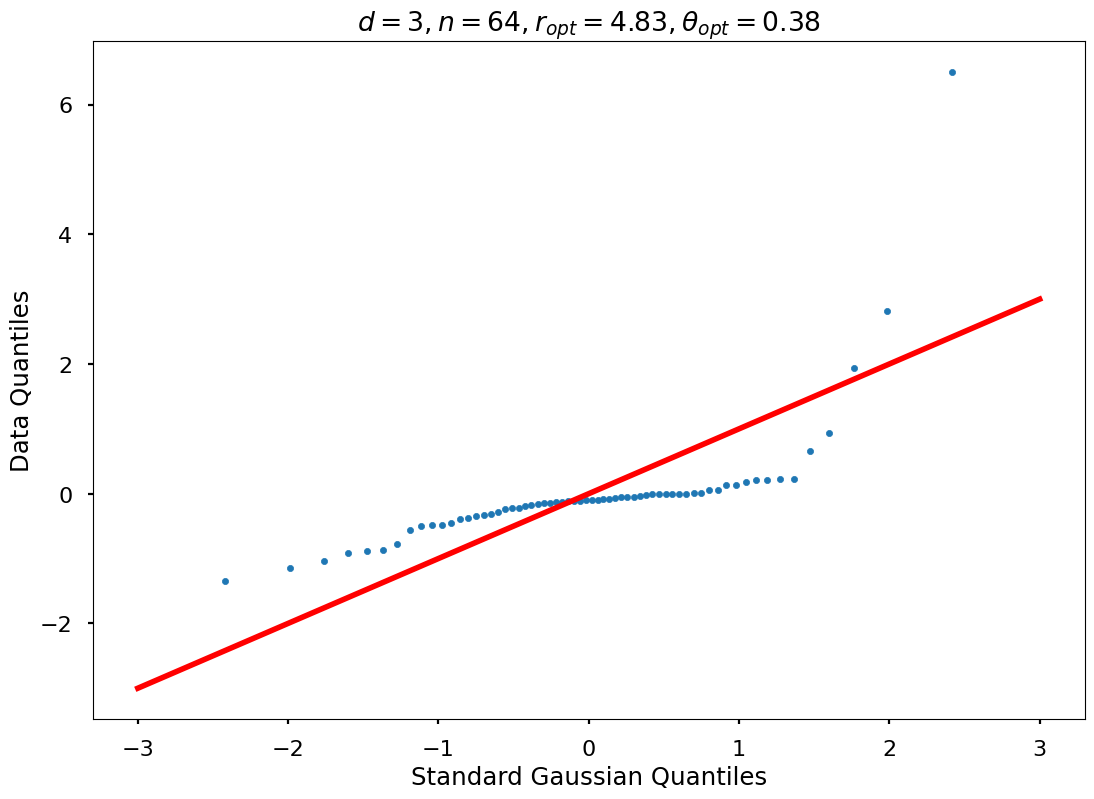

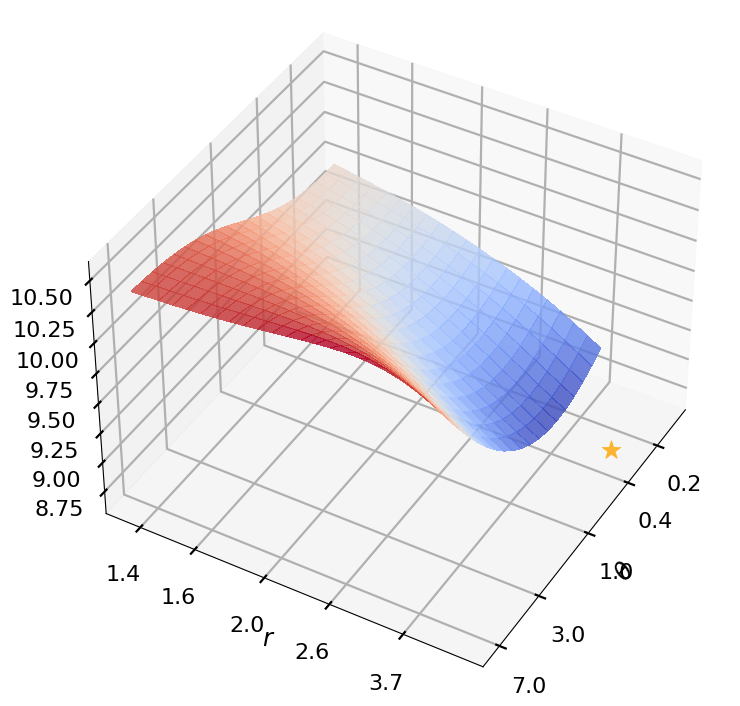

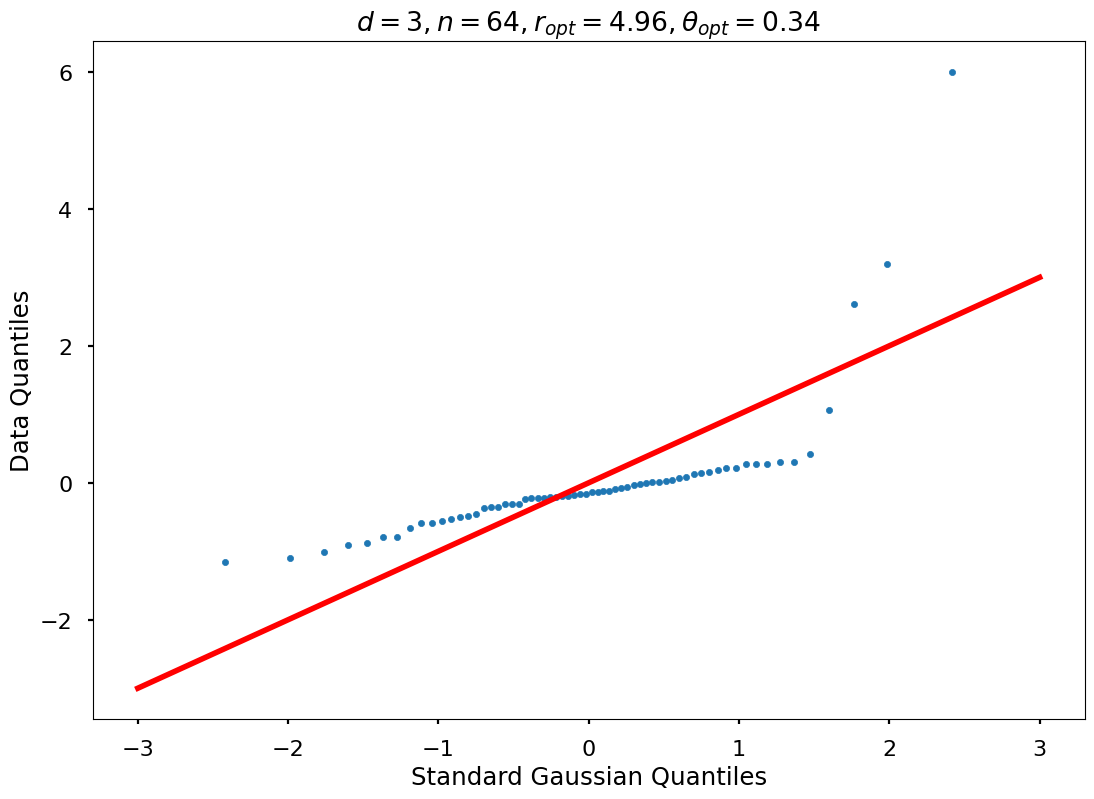

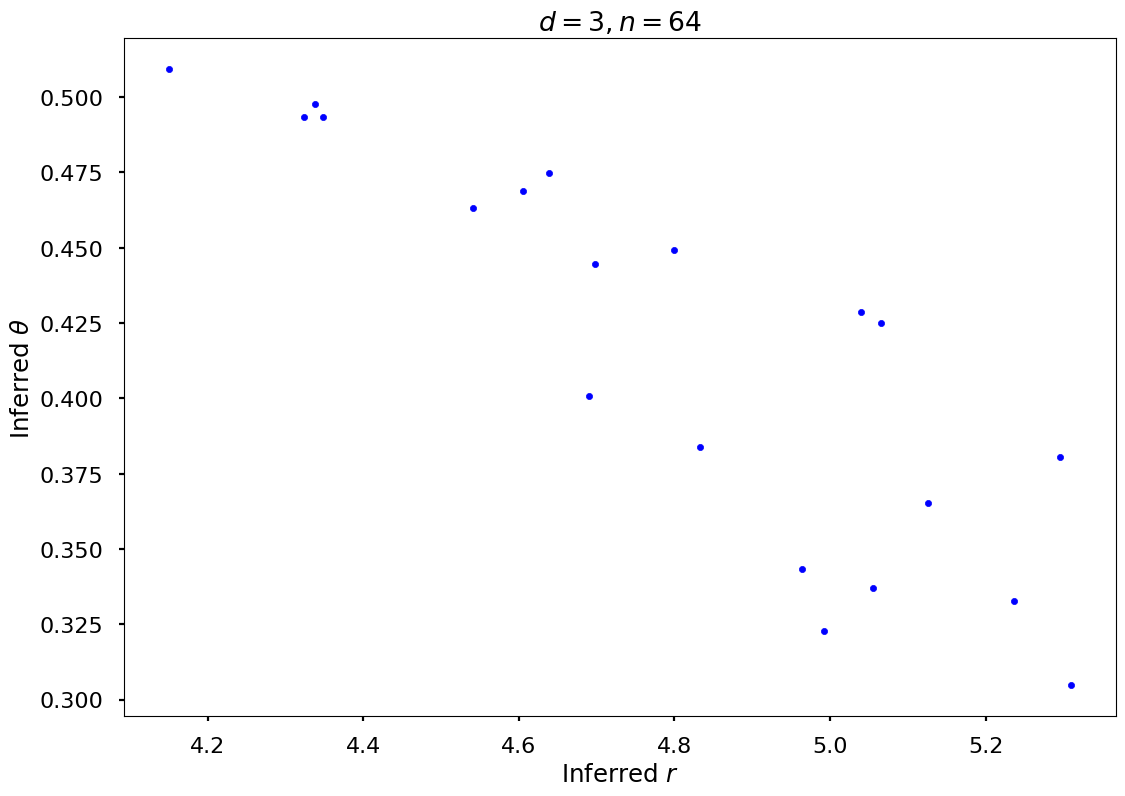

In [11]:
fwh = 1
dim = 3
npts = 2 ** 6
nRep = 20
nPlot = 2
[_, rOptAll, thOptAll, fName] = \
    gaussian_diagnostics_engine(fwh, dim, npts, None, None, nRep, nPlot)

## Plot Exponential Cosine example
figH = plt.figure()
plt.scatter(rOptAll, thOptAll, s=20, color='blue')
# axis([4 6 0.1 10])
# set(gca,'yscale','log')
plt.title(f'$d = {dim}, n = {npts}$')
plt.xlabel('Inferred $r$')
plt.ylabel('Inferred $\\theta$')
# print(f'{fName}-rthInfer-n-{npts}-d-{dim}')
figH.savefig(f'{fName}-rthInfer-n-{npts}-d-{dim}.jpg')

In [12]:
# close all the previous plots to freeup memory
plt.close('all')

## Example 2: Random function

0: thetaOptAppx=0.36788, rOptAppx=1.36788, objMinAppx=7.35704, objMin=7.35453
	 r =  1.50000, rOpt = 1.27176, theta =  0.25000, thetaOpt = 0.28772

1: thetaOptAppx=7.38906, rOptAppx=1.36788, objMinAppx=6.92820, objMin=6.87622
	 r =  1.50000, rOpt = 1.27176, theta =  0.25000, thetaOpt = 0.28772

1: thetaOptAppx=7.38906, rOptAppx=1.36788, objMinAppx=6.92820, objMin=6.87622
	 r =  1.50000, rOpt = 1.00000, theta =  0.25000, thetaOpt = 18.56373

	 r =  1.50000, rOpt = 1.00000, theta =  0.25000, thetaOpt = 18.56373

2: thetaOptAppx=0.44933, rOptAppx=1.36788, objMinAppx=7.29837, objMin=7.23007
2: thetaOptAppx=0.44933, rOptAppx=1.36788, objMinAppx=7.29837, objMin=7.23007
	 r =  1.50000, rOpt = 1.00000, theta =  0.25000, thetaOpt = 0.15992

	 r =  1.50000, rOpt = 1.00000, theta =  0.25000, thetaOpt = 0.15992

3: thetaOptAppx=0.36788, rOptAppx=1.60653, objMinAppx=6.78562, objMin=6.78542
	 r =  1.50000, rOpt = 1.61538, theta =  0.25000, thetaOpt = 0.34718

3: thetaOptAppx=0.36788, rOptAppx=1.6065

/var/folders/l3/wz4prc5d4kv118mgp30jj3_m0000gn/T/ipykernel_82115/1027096213.py:2


	 r = 2, rOpt = 1.89701, theta =  0.25000, thetaOpt = 0.41148

2: thetaOptAppx=0.13534, rOptAppx=1.67032, objMinAppx=5.92915, objMin=5.91076
2: thetaOptAppx=0.13534, rOptAppx=1.67032, objMinAppx=5.92915, objMin=5.91076
	 r = 2, rOpt = 1.63756, theta =  0.25000, thetaOpt = 0.05835

3: thetaOptAppx=0.16530, rOptAppx=1.81873, objMinAppx=6.31692, objMin=6.31657
	 r = 2, rOpt = 1.78762, theta =  0.25000, thetaOpt = 0.15822

	 r = 2, rOpt = 1.63756, theta =  0.25000, thetaOpt = 0.05835

3: thetaOptAppx=0.16530, rOptAppx=1.81873, objMinAppx=6.31692, objMin=6.31657
	 r = 2, rOpt = 1.78762, theta =  0.25000, thetaOpt = 0.15822

4: thetaOptAppx=0.16530, rOptAppx=1.90484, objMinAppx=6.02959, objMin=6.02871
	 r = 2, rOpt = 1.95115, theta =  0.25000, thetaOpt = 0.17273

4: thetaOptAppx=0.16530, rOptAppx=1.90484, objMinAppx=6.02959, objMin=6.02871
	 r = 2, rOpt = 1.95115, theta =  0.25000, thetaOpt = 0.17273

0: thetaOptAppx=6.04965, rOptAppx=2.22140, objMinAppx=9.81313, objMin=9.81255
0: thetaOptAp

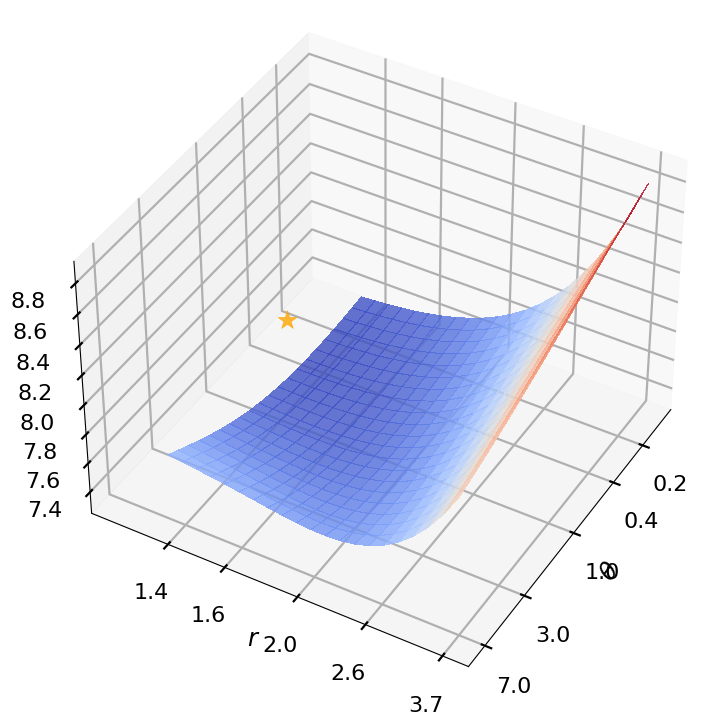

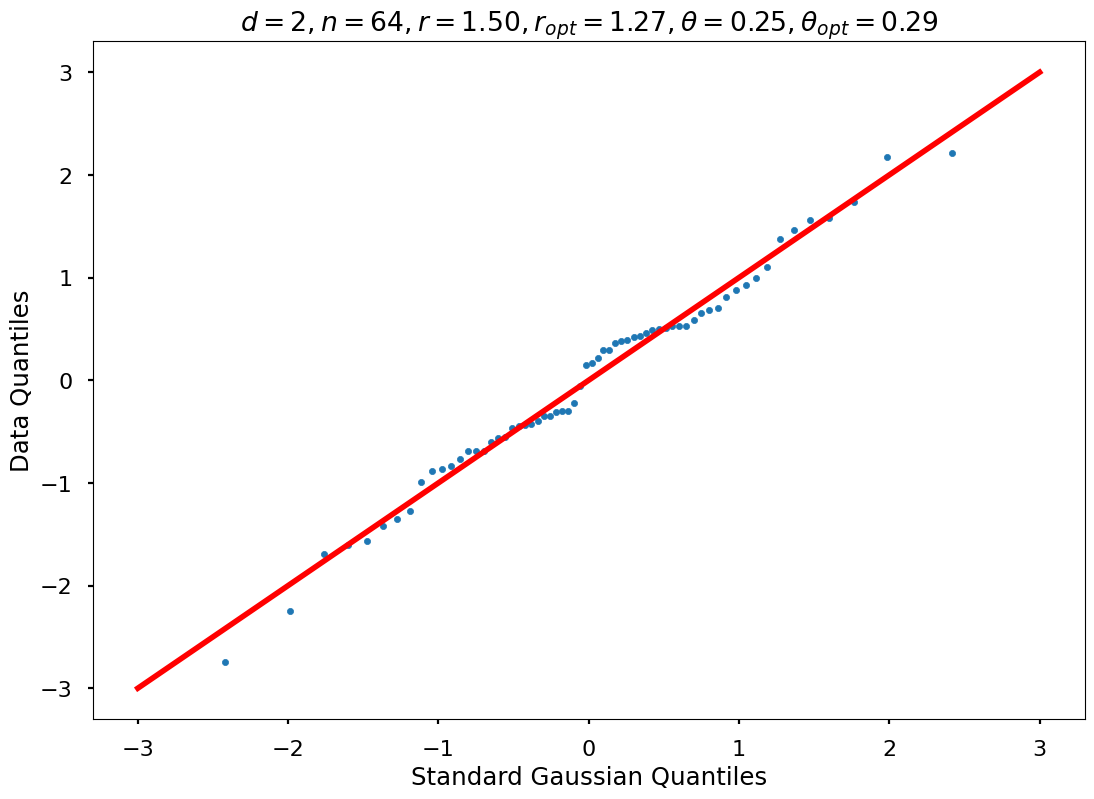

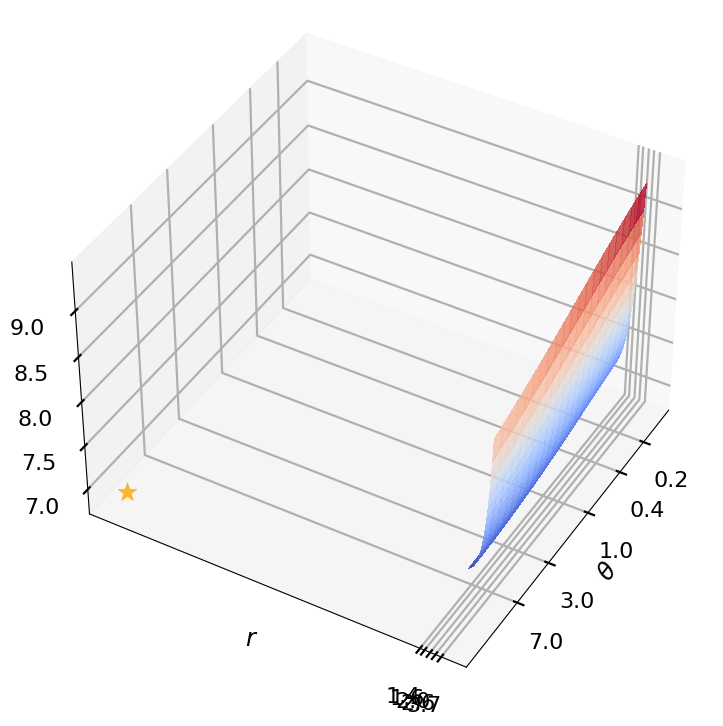

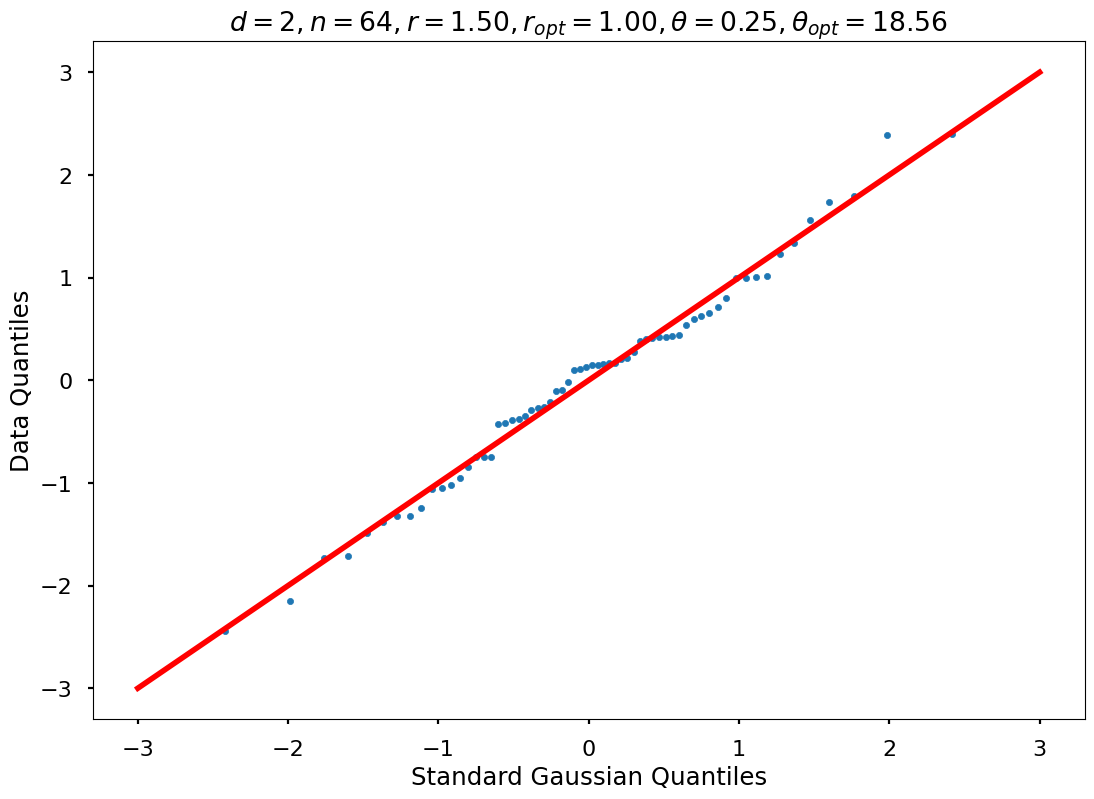

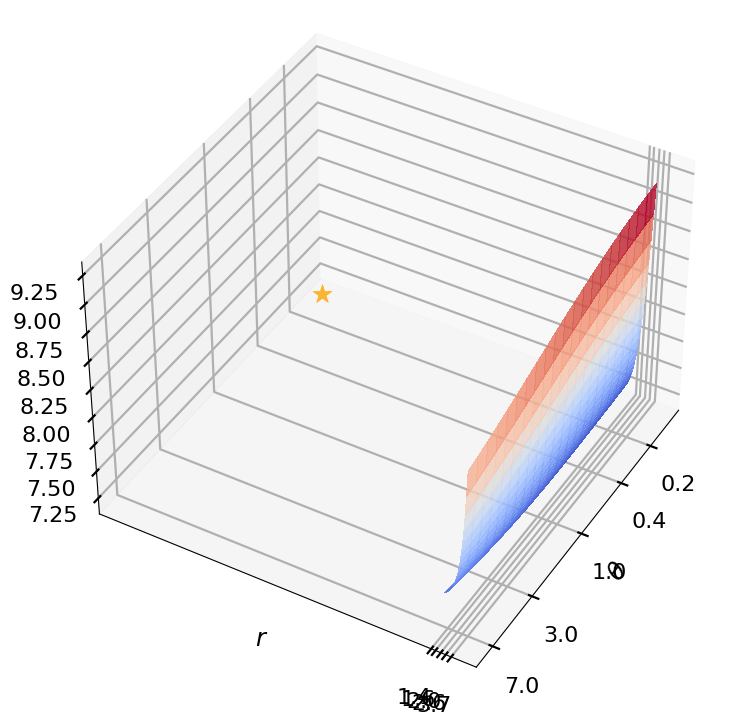

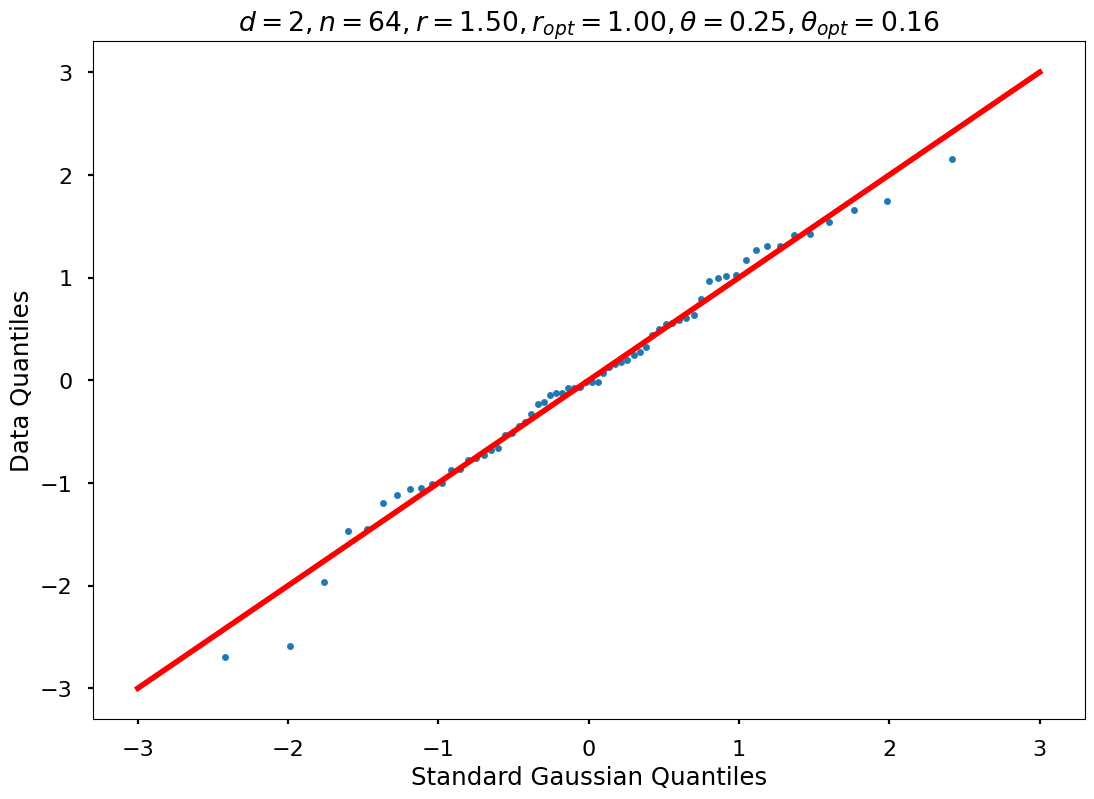

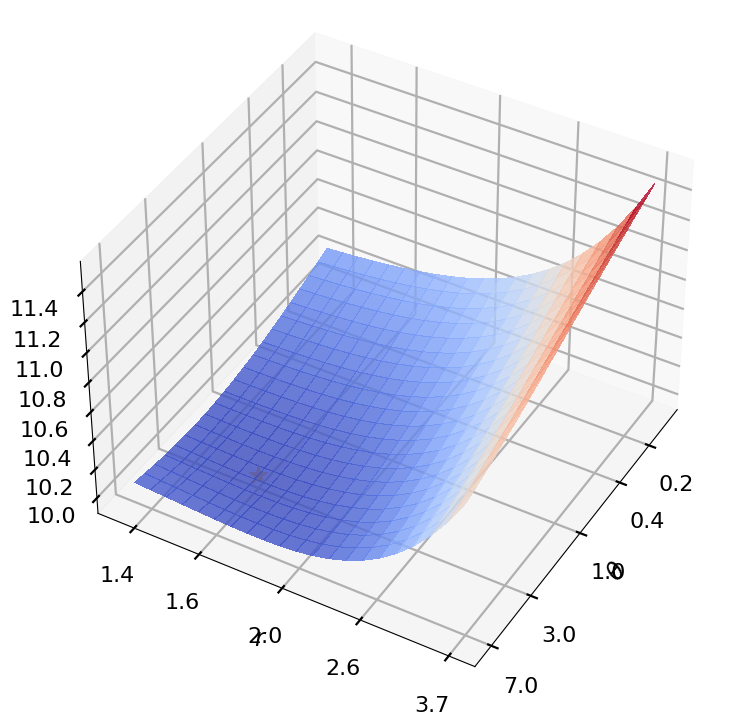

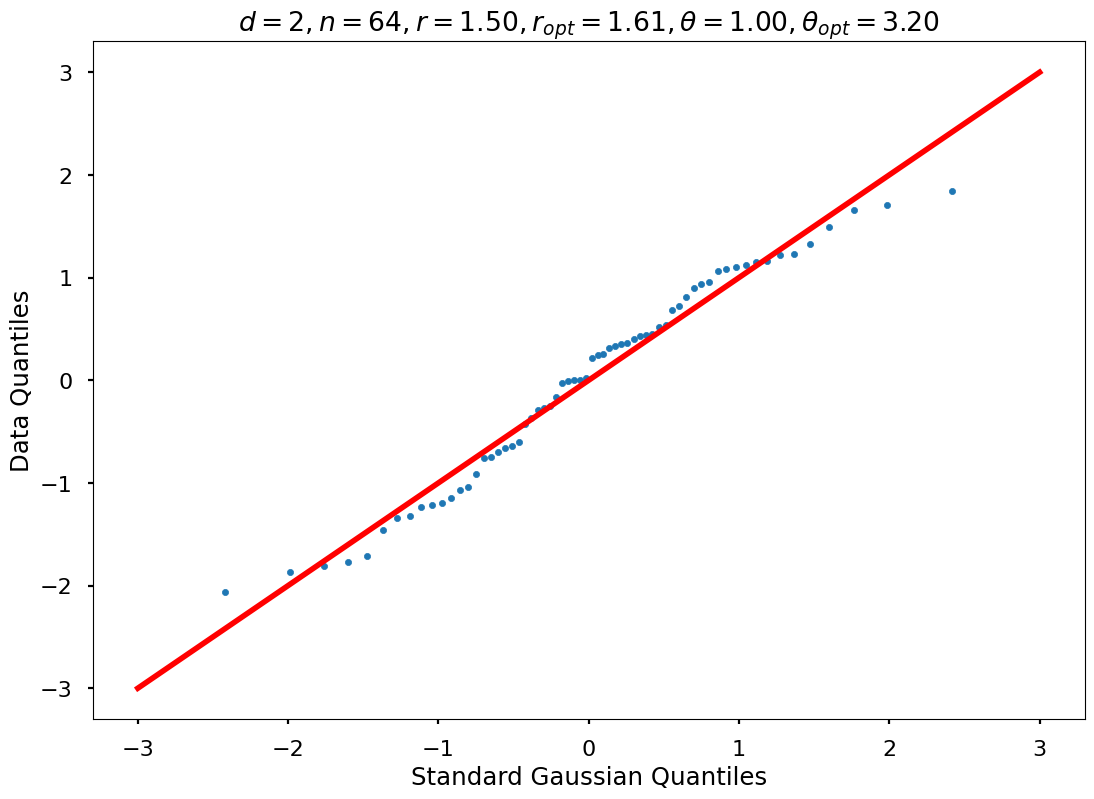

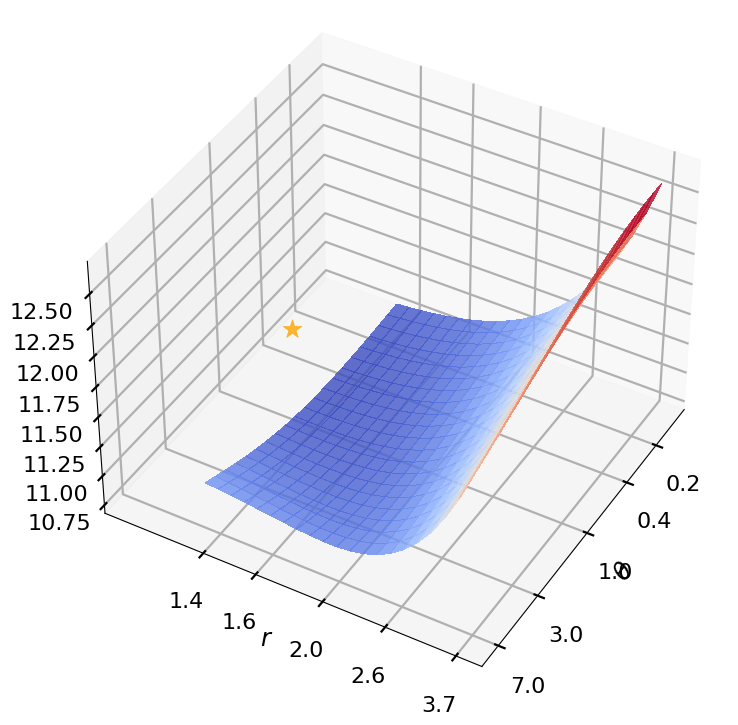

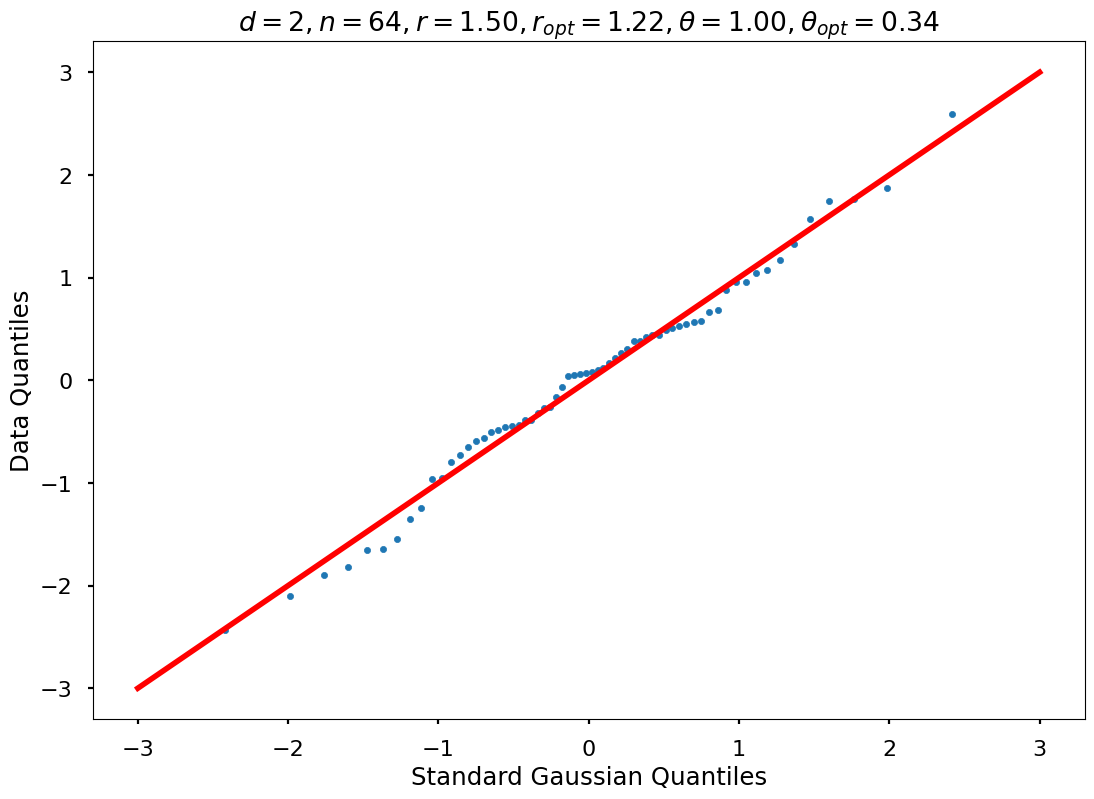

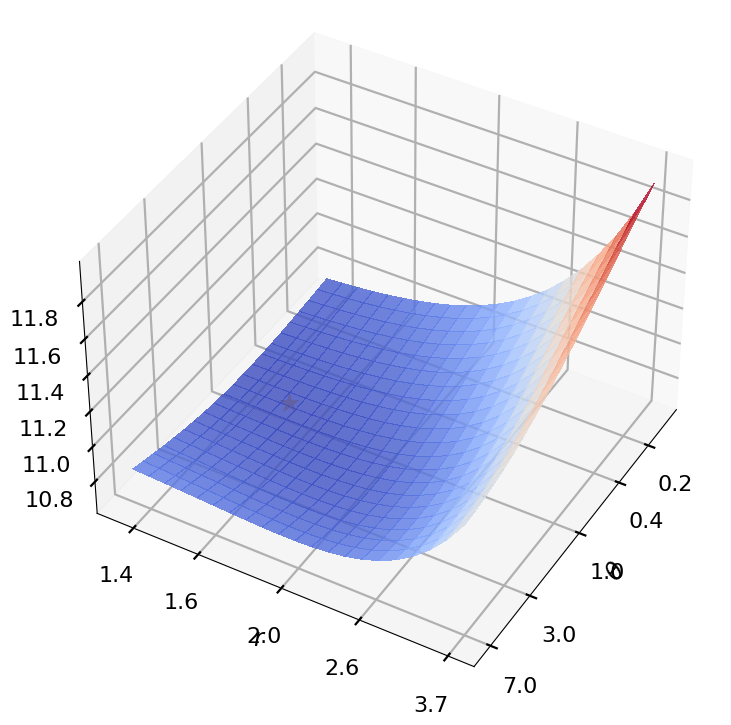

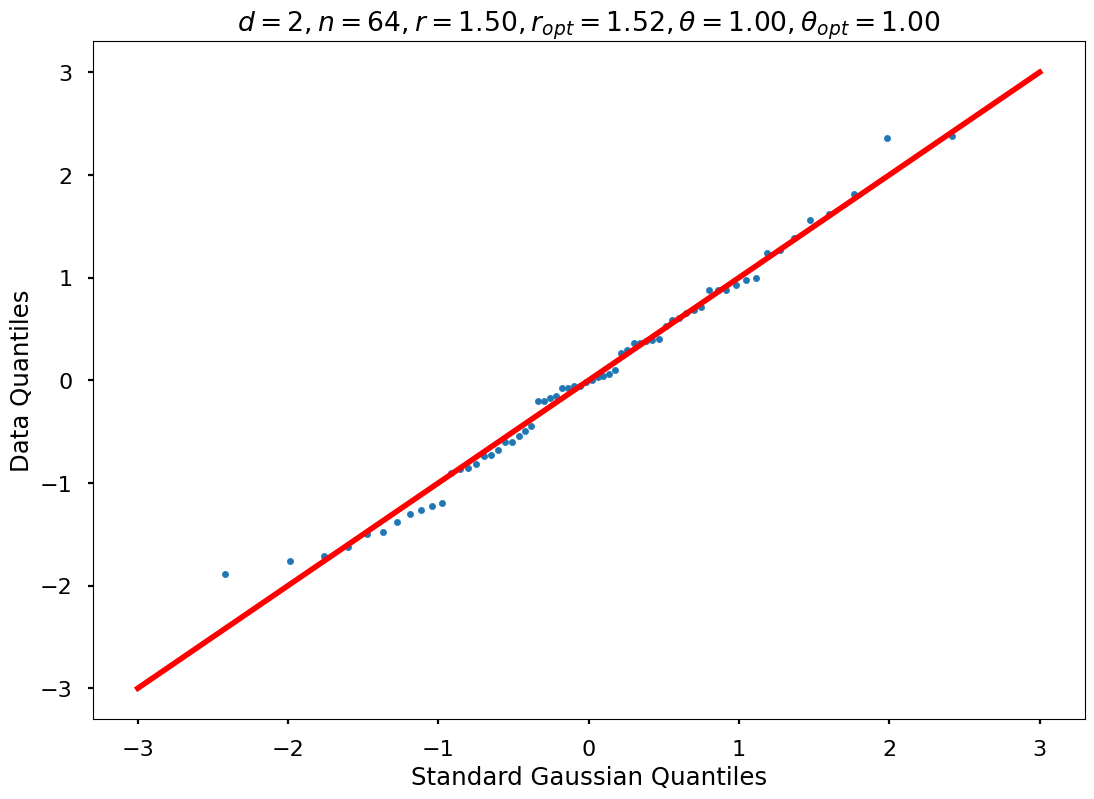

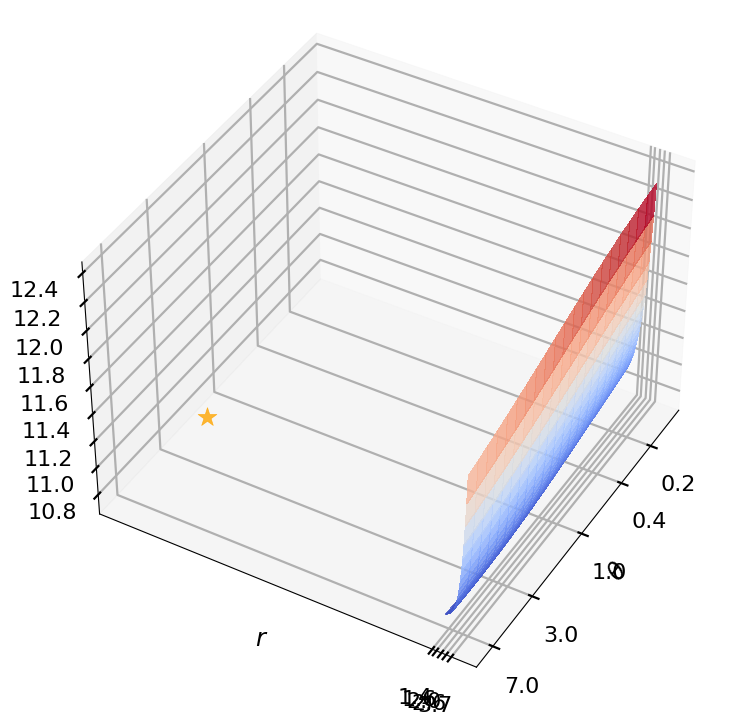

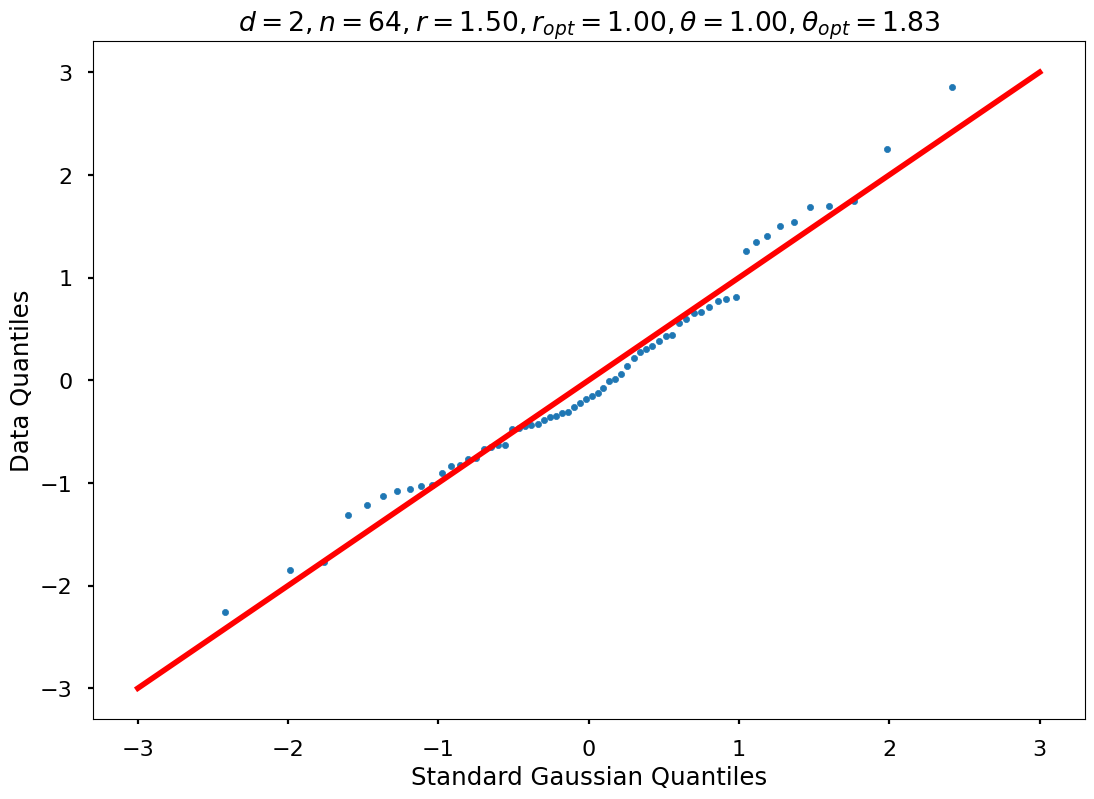

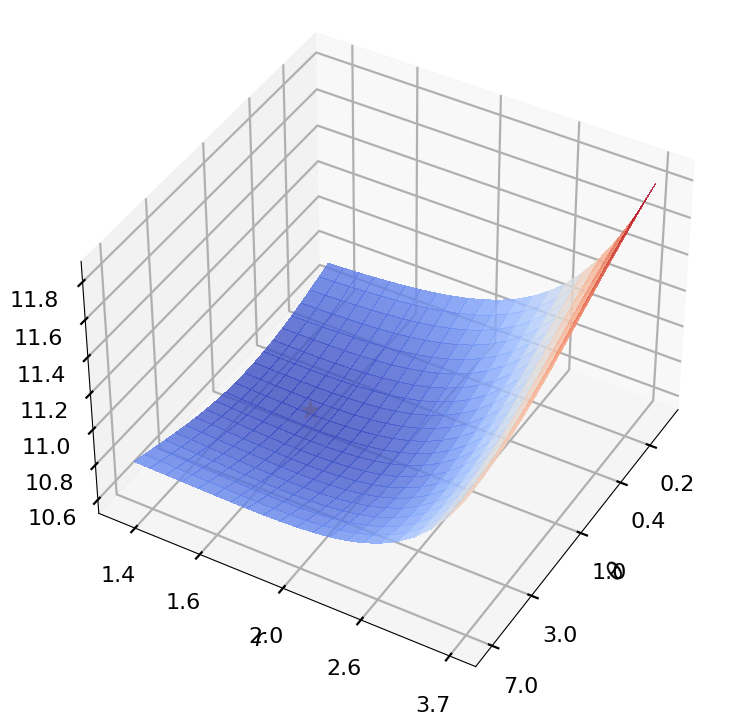

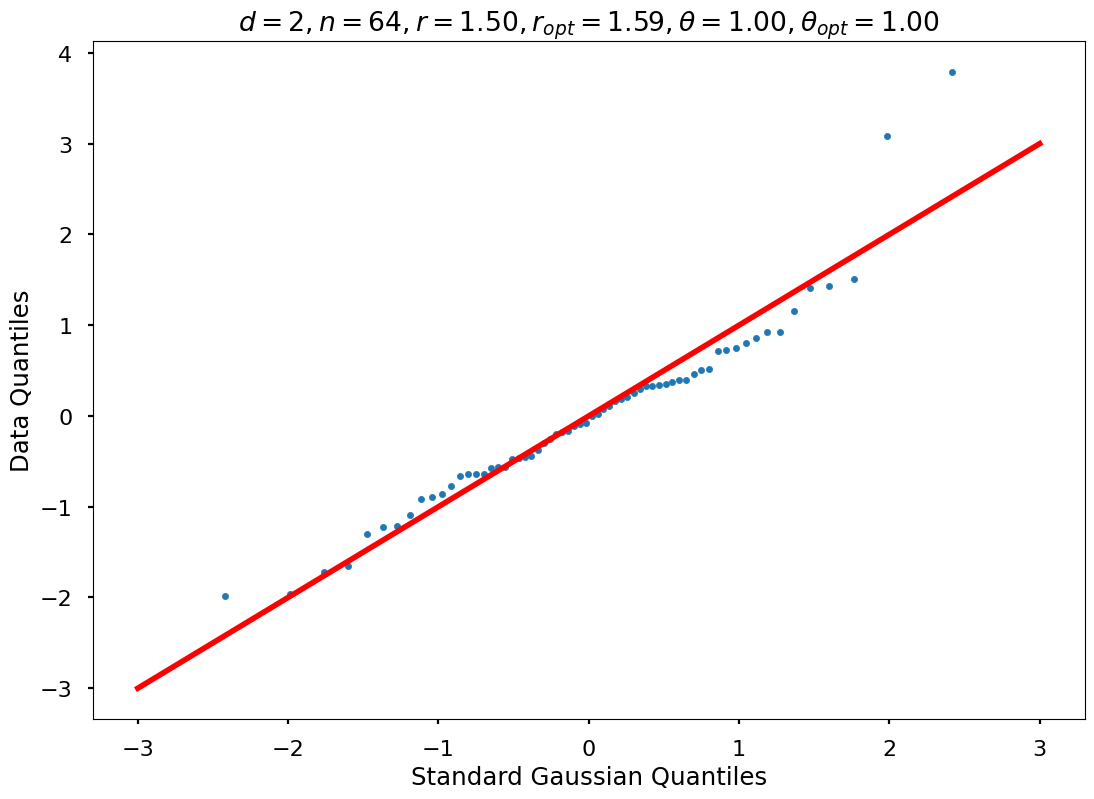

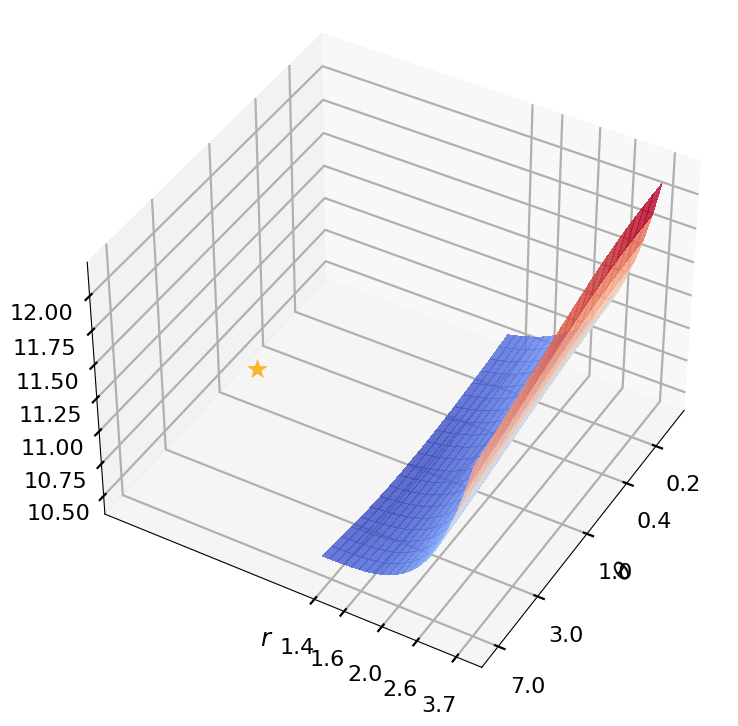

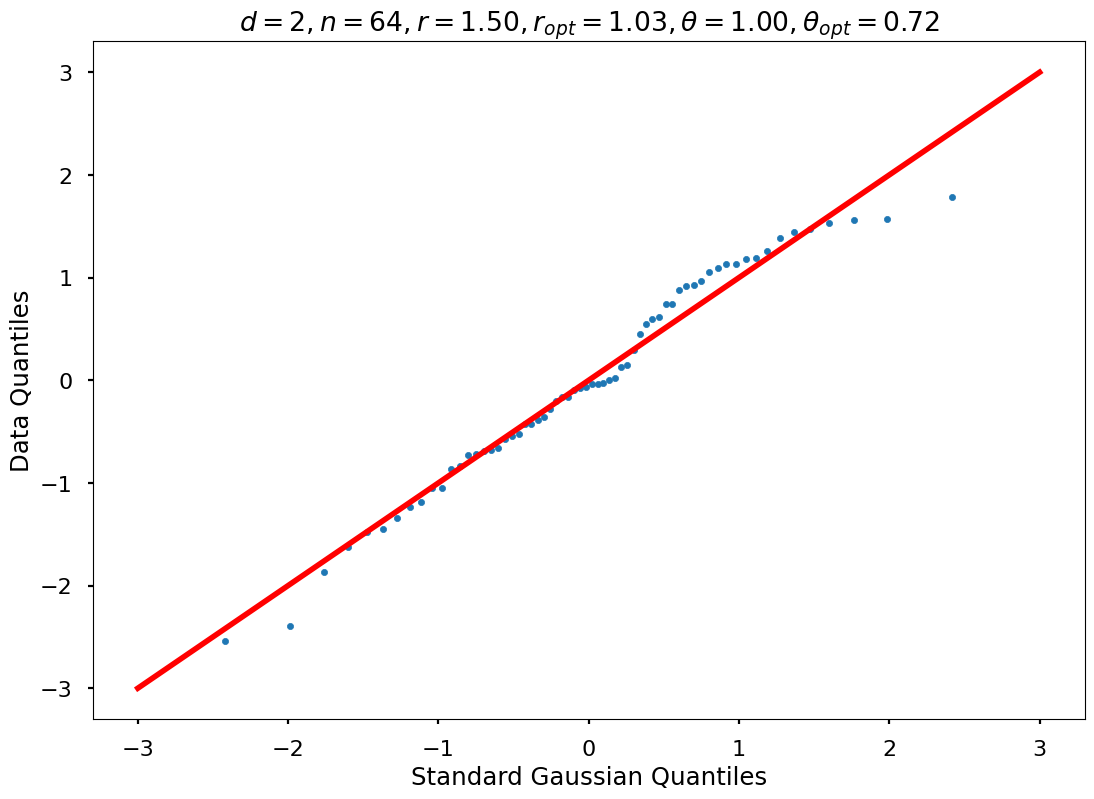

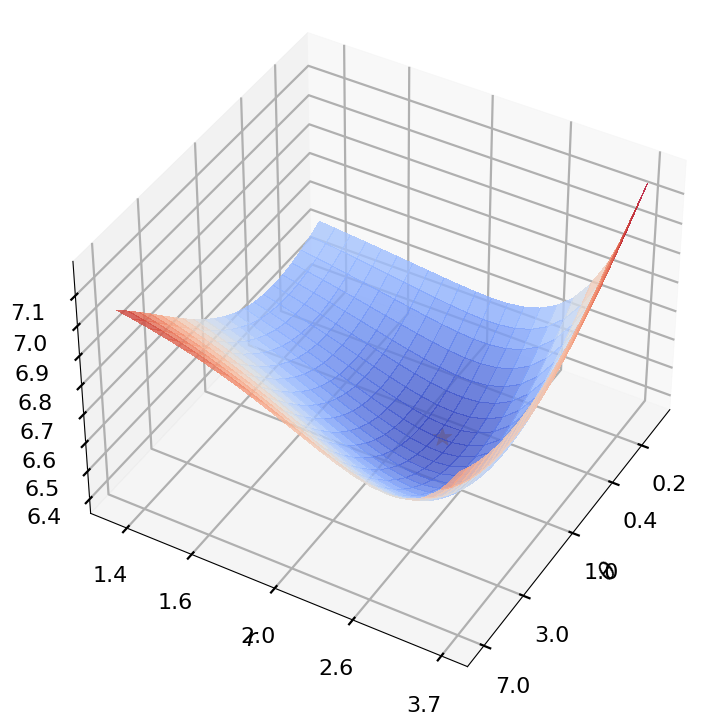

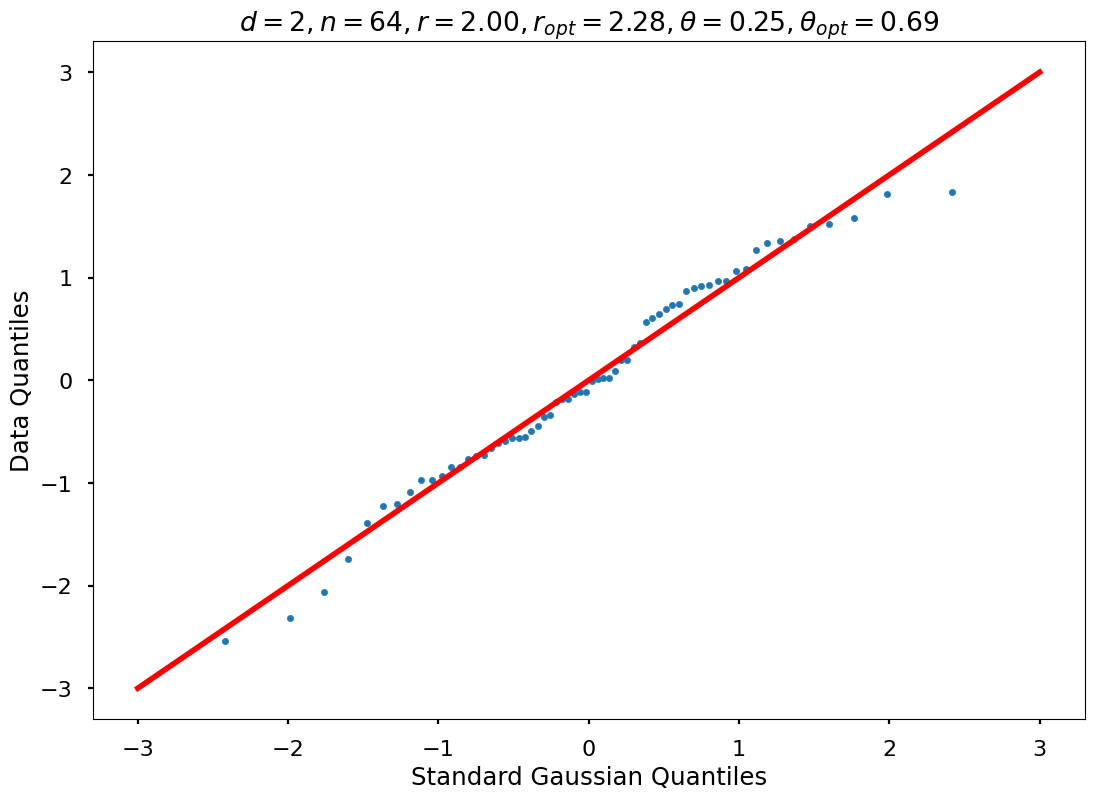

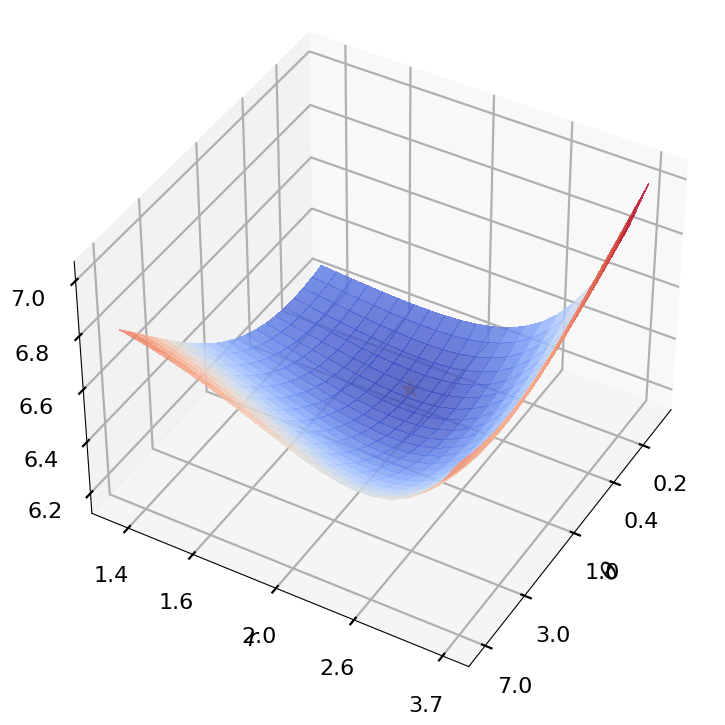

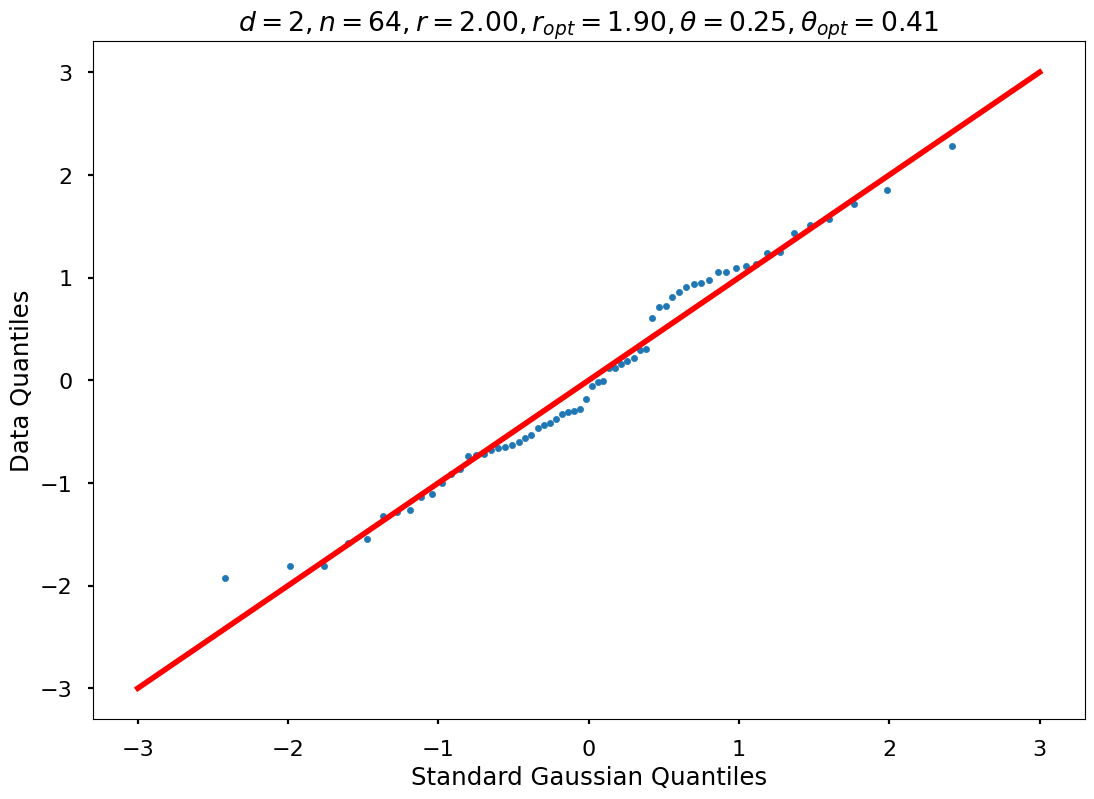

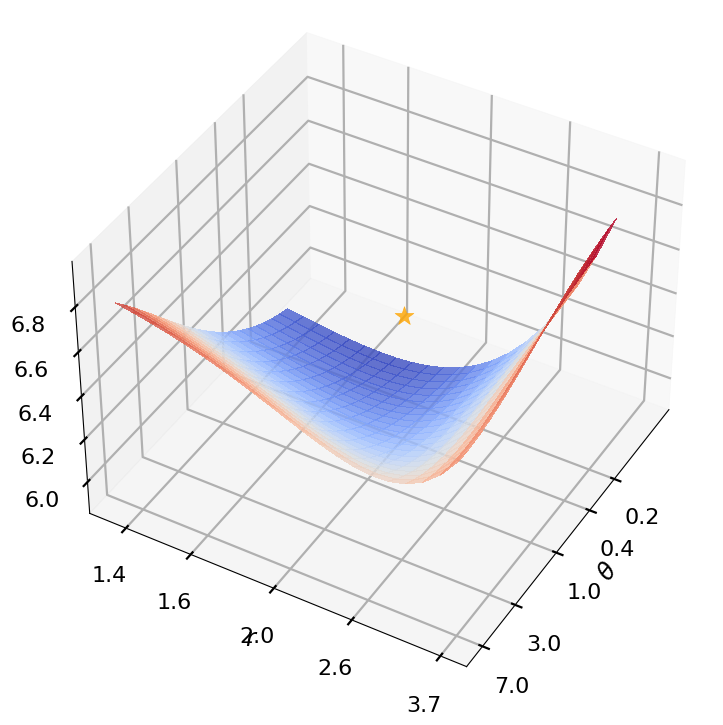

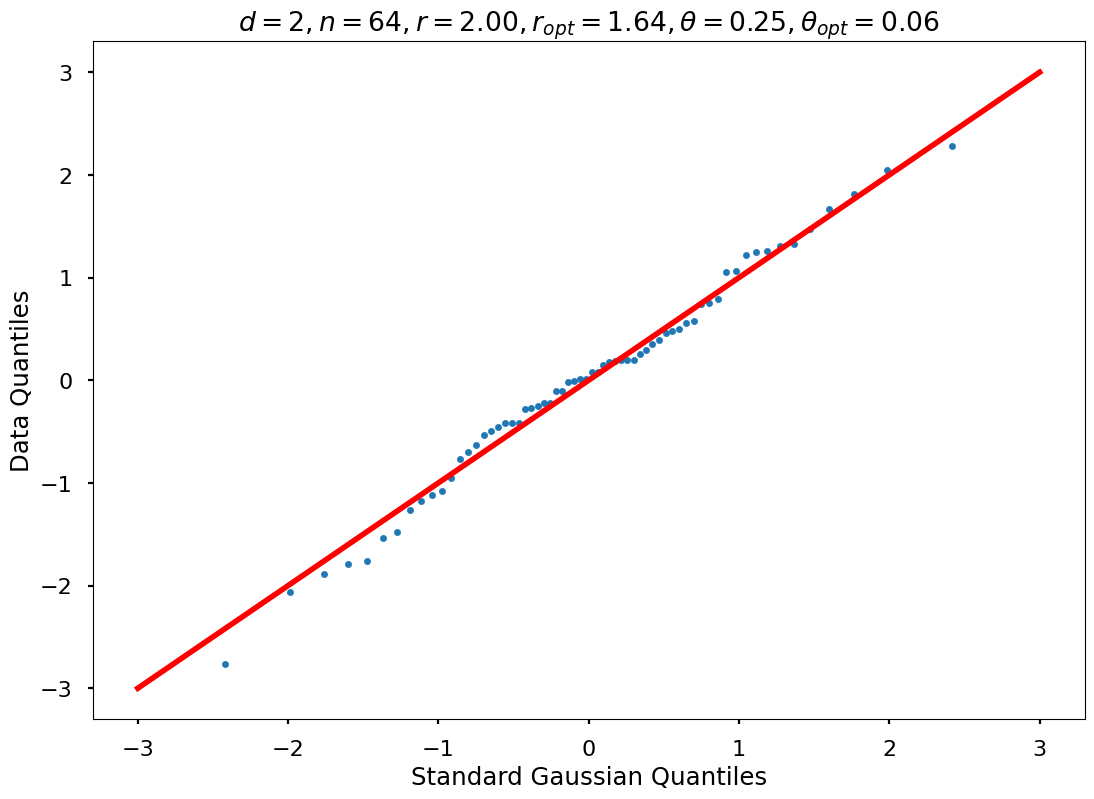

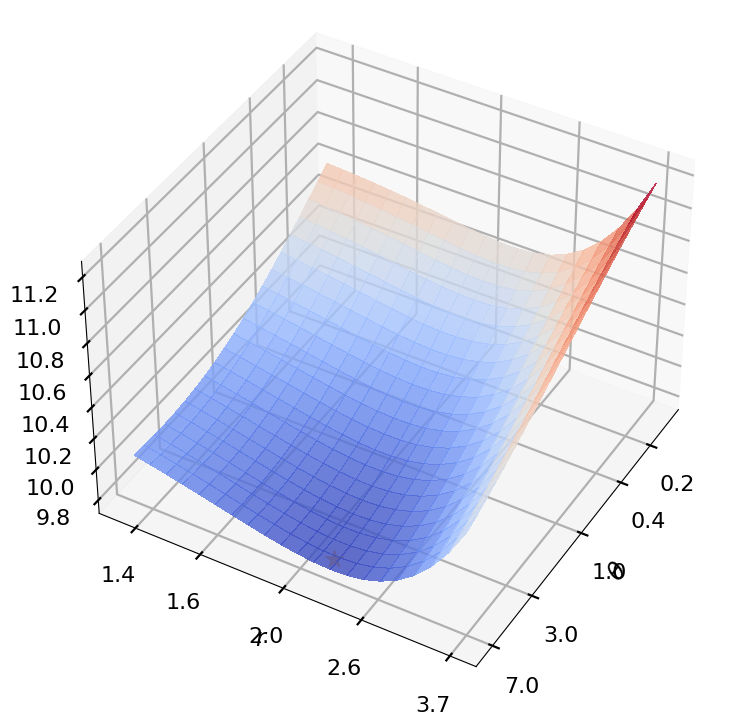

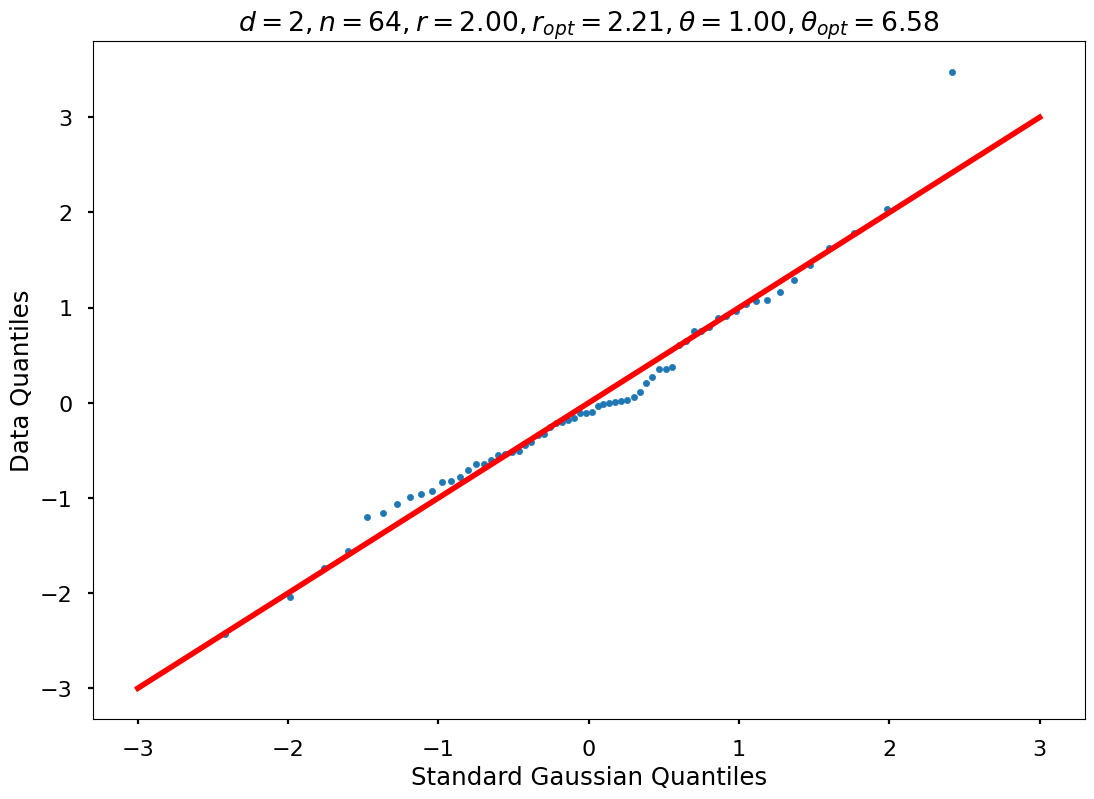

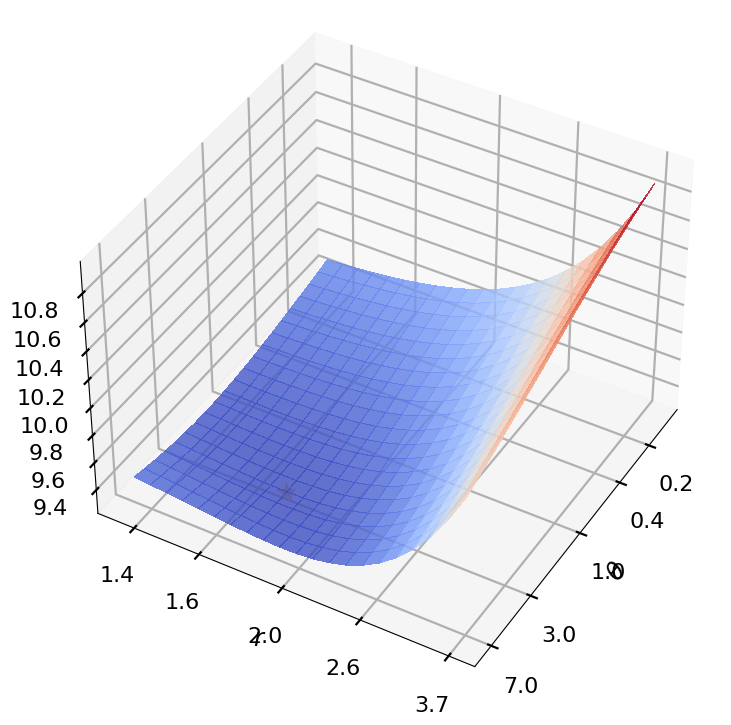

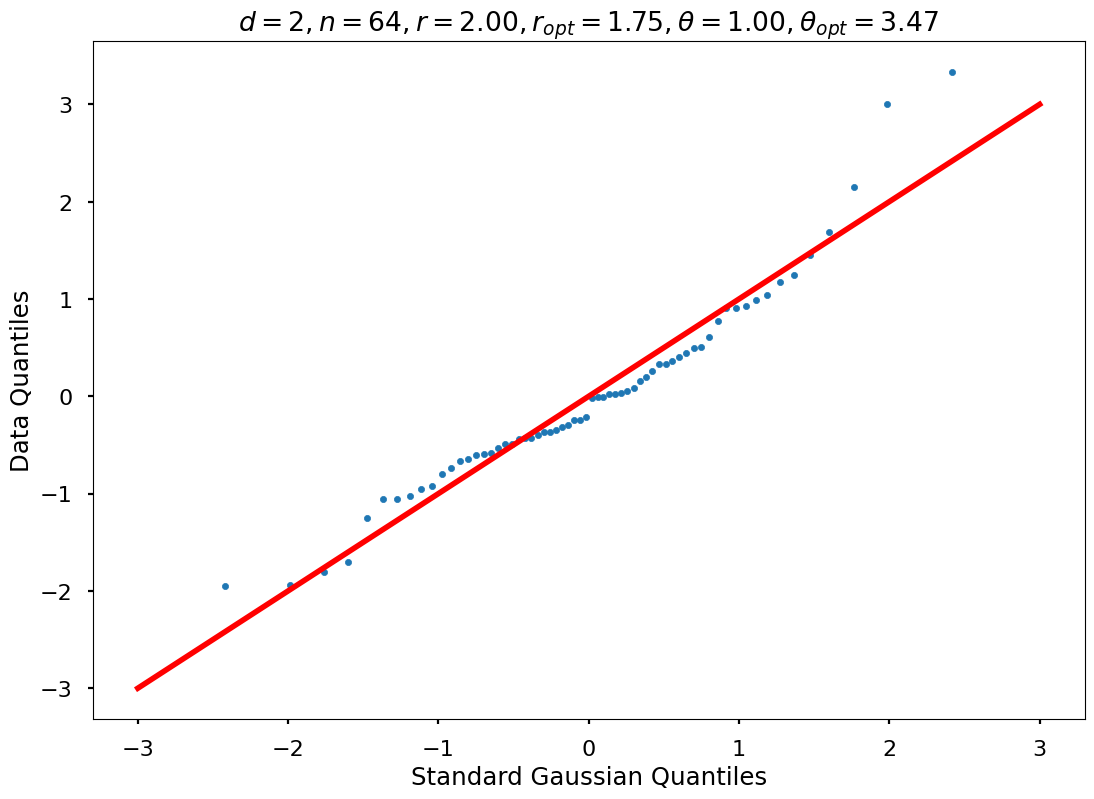

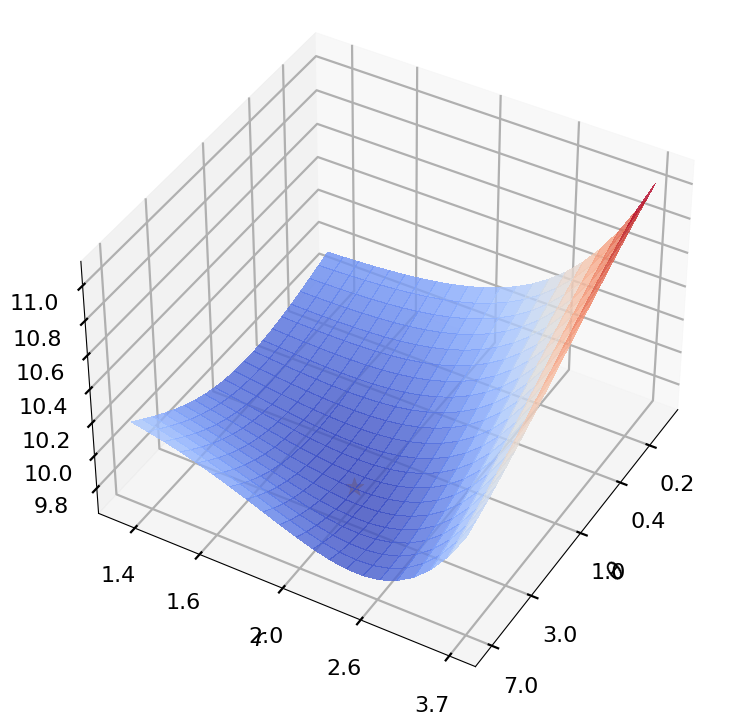

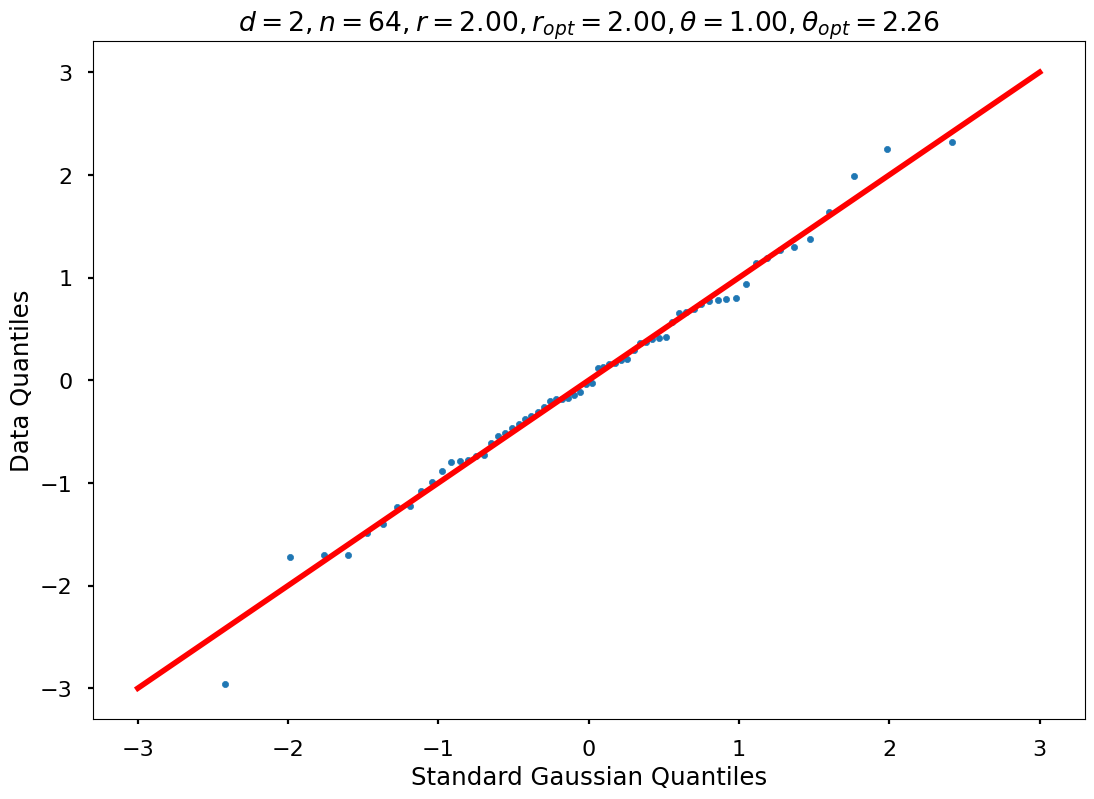

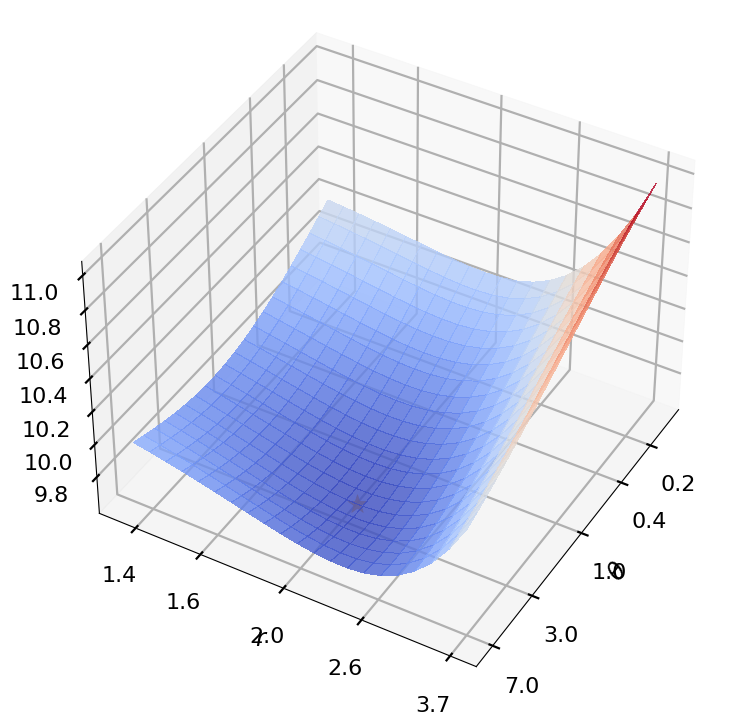

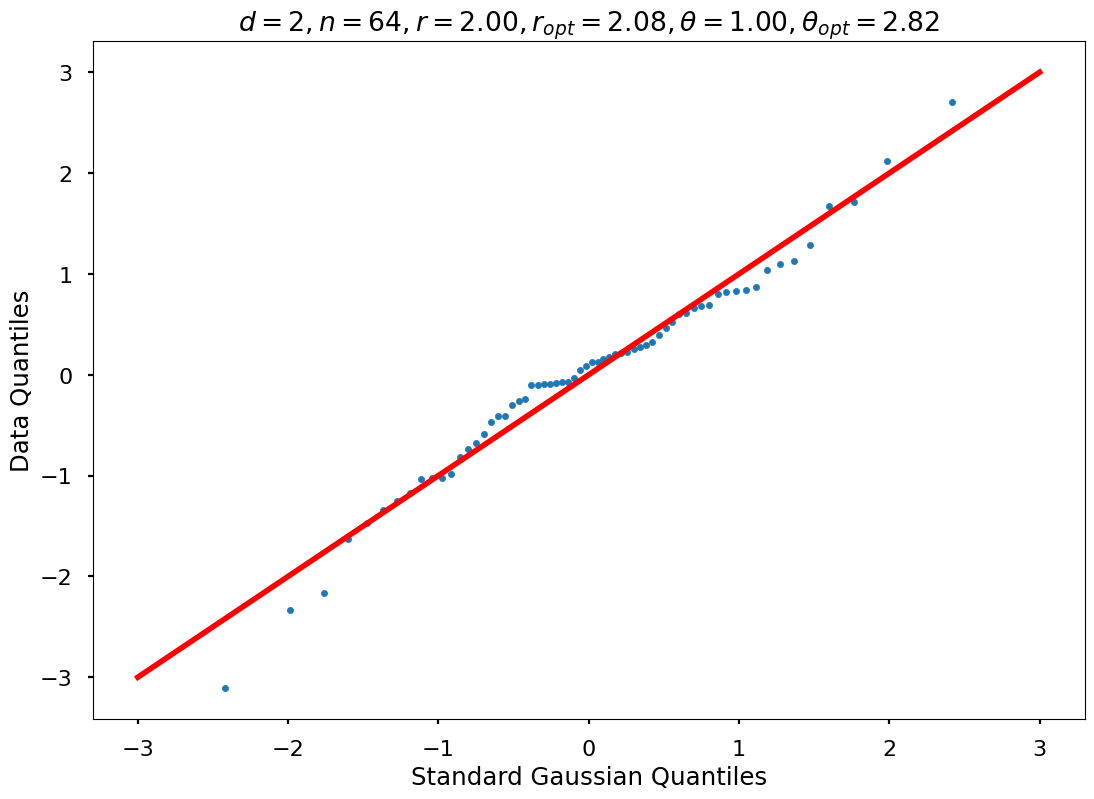

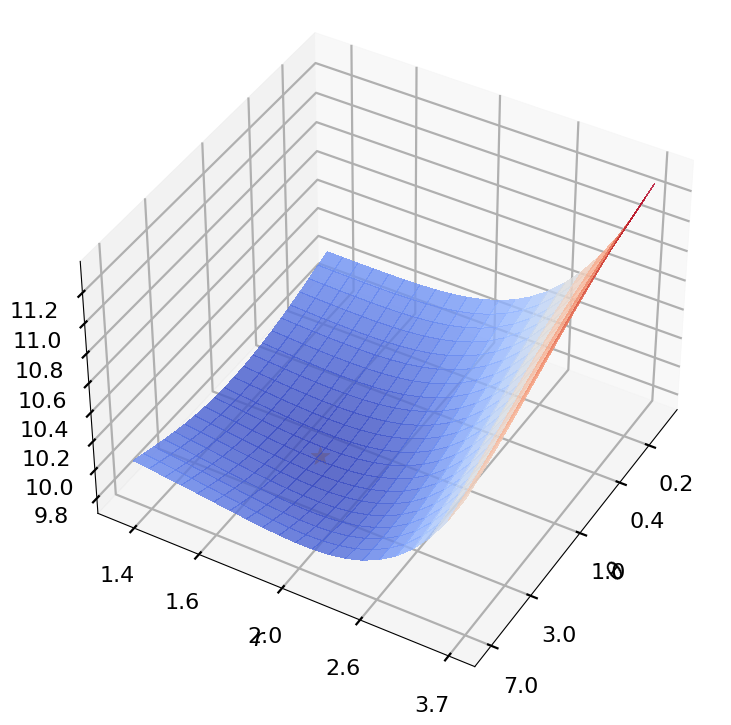

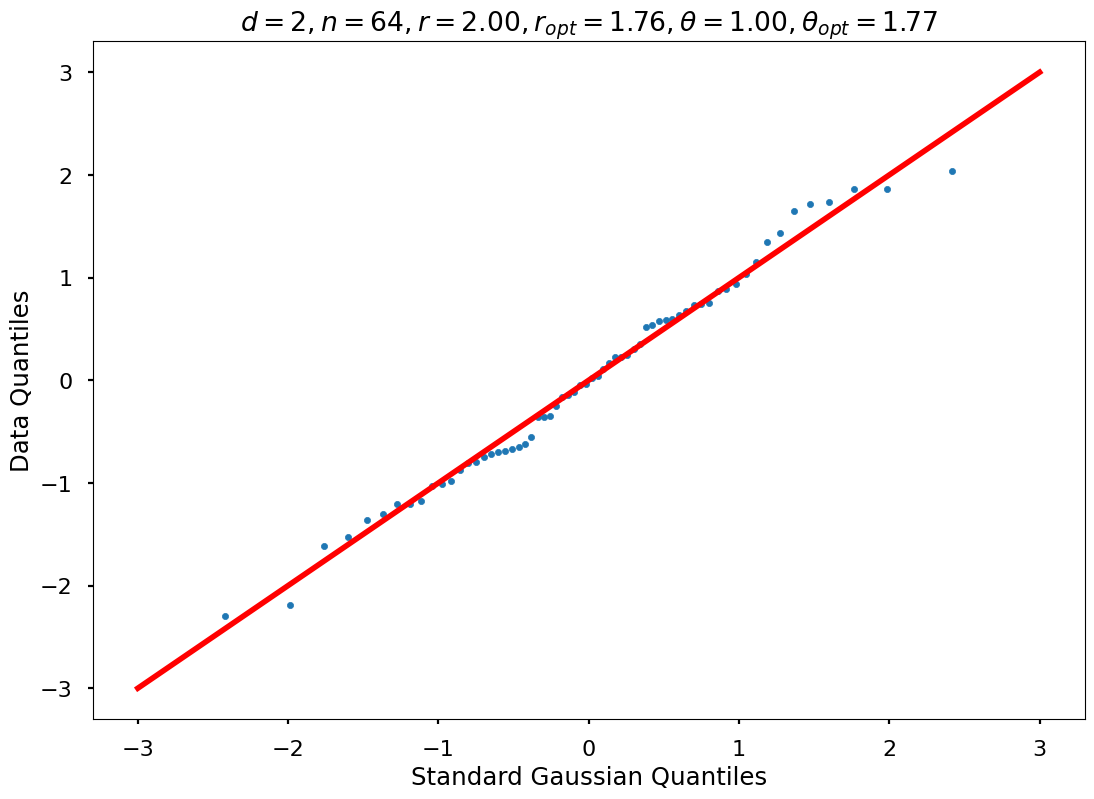

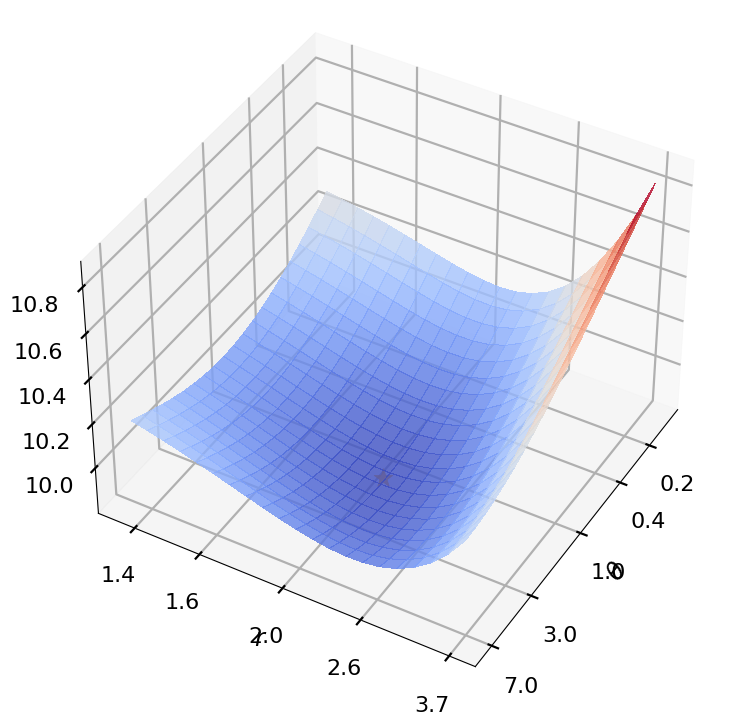

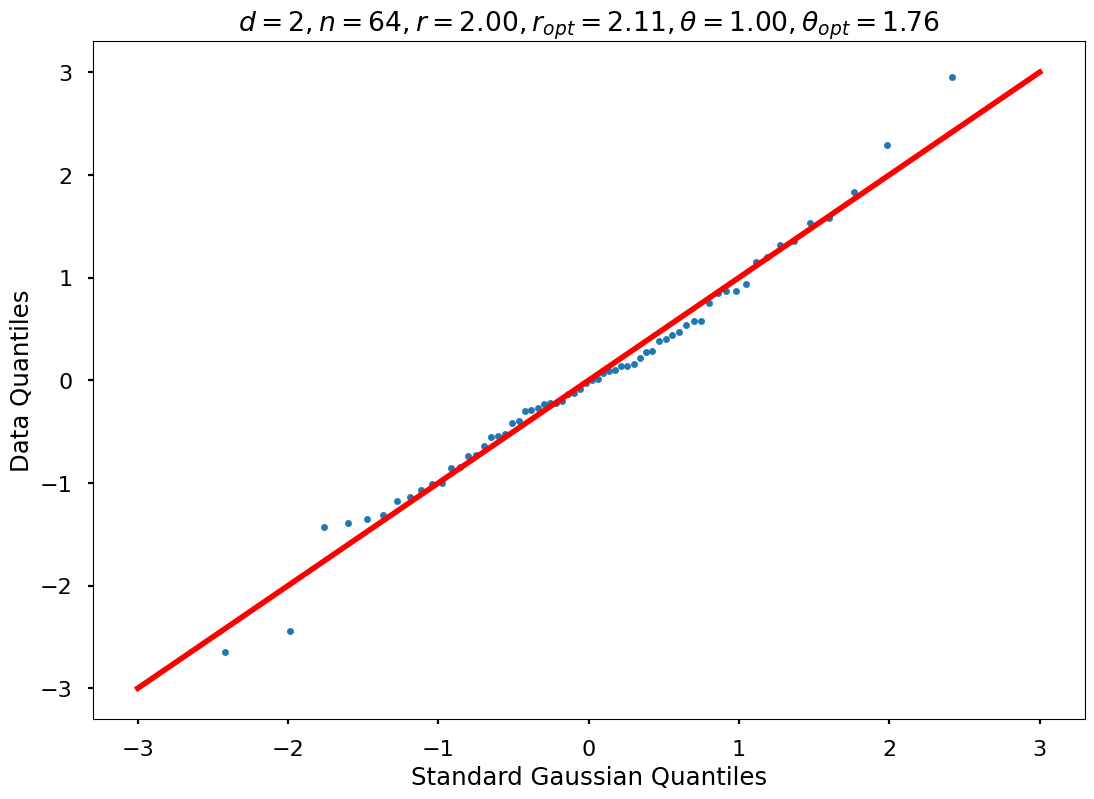

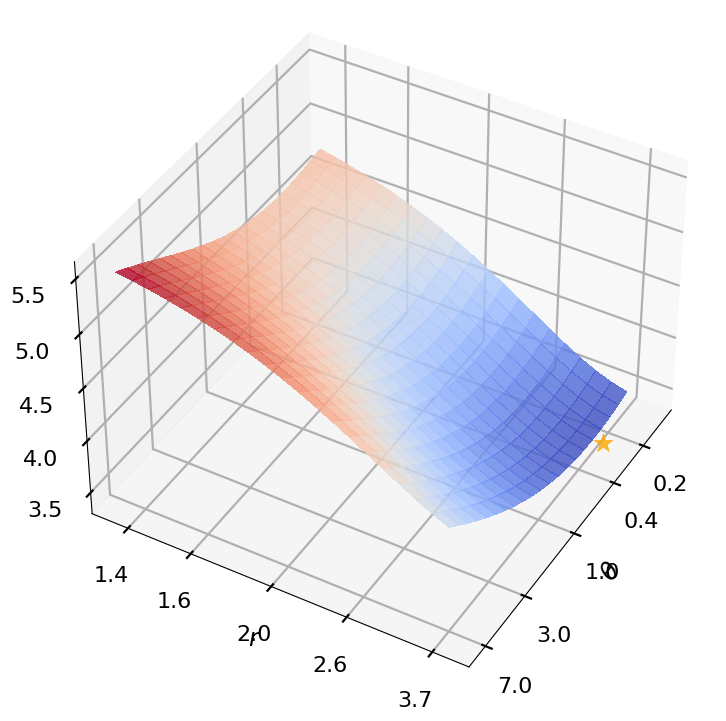

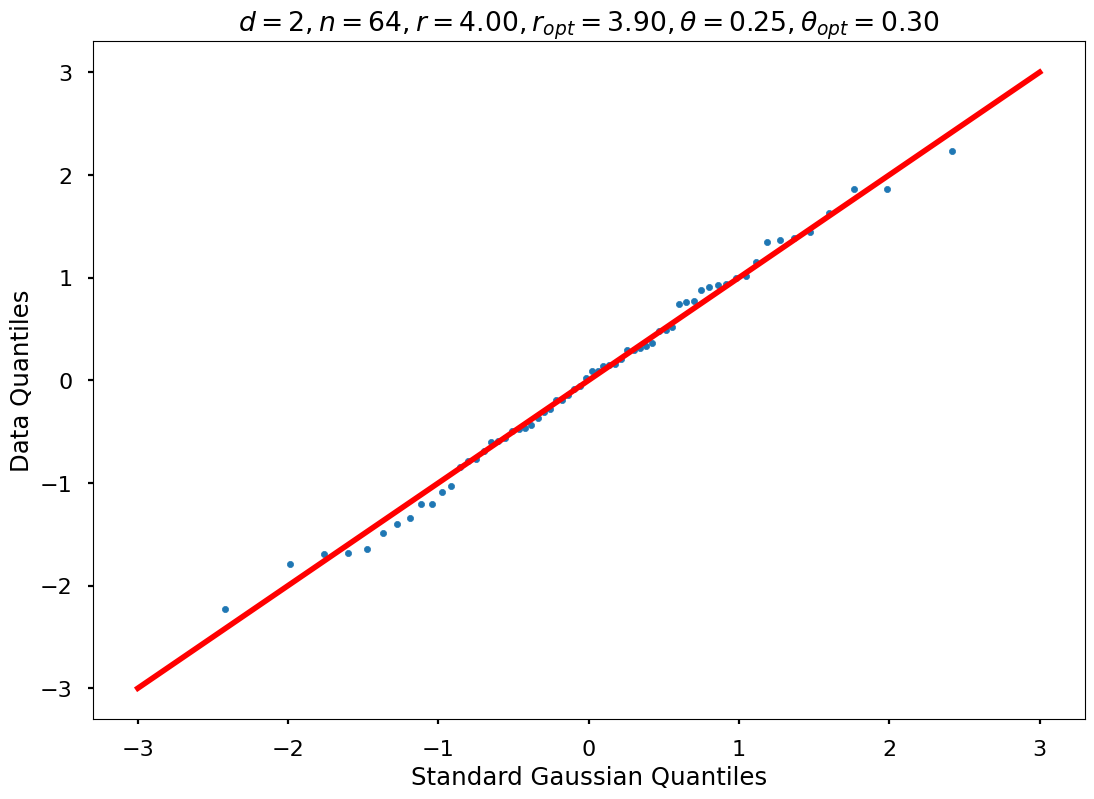

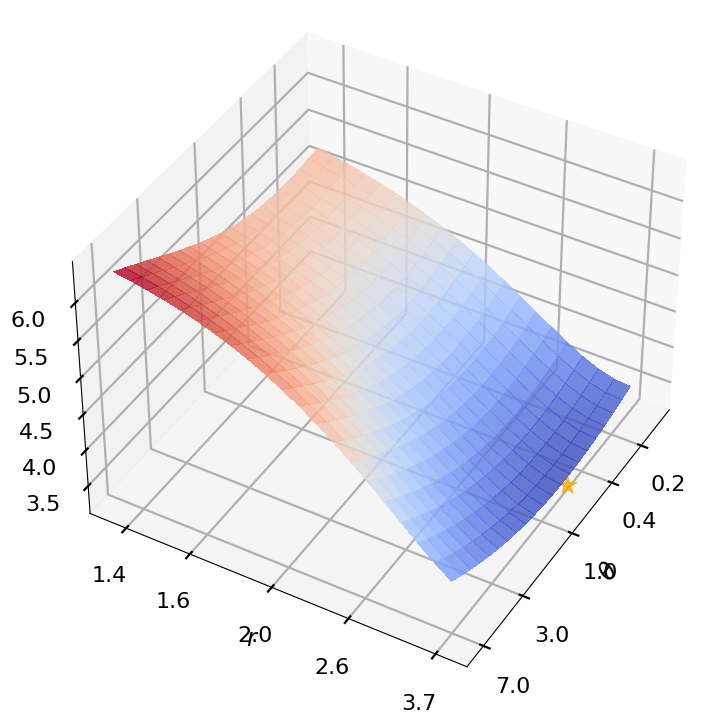

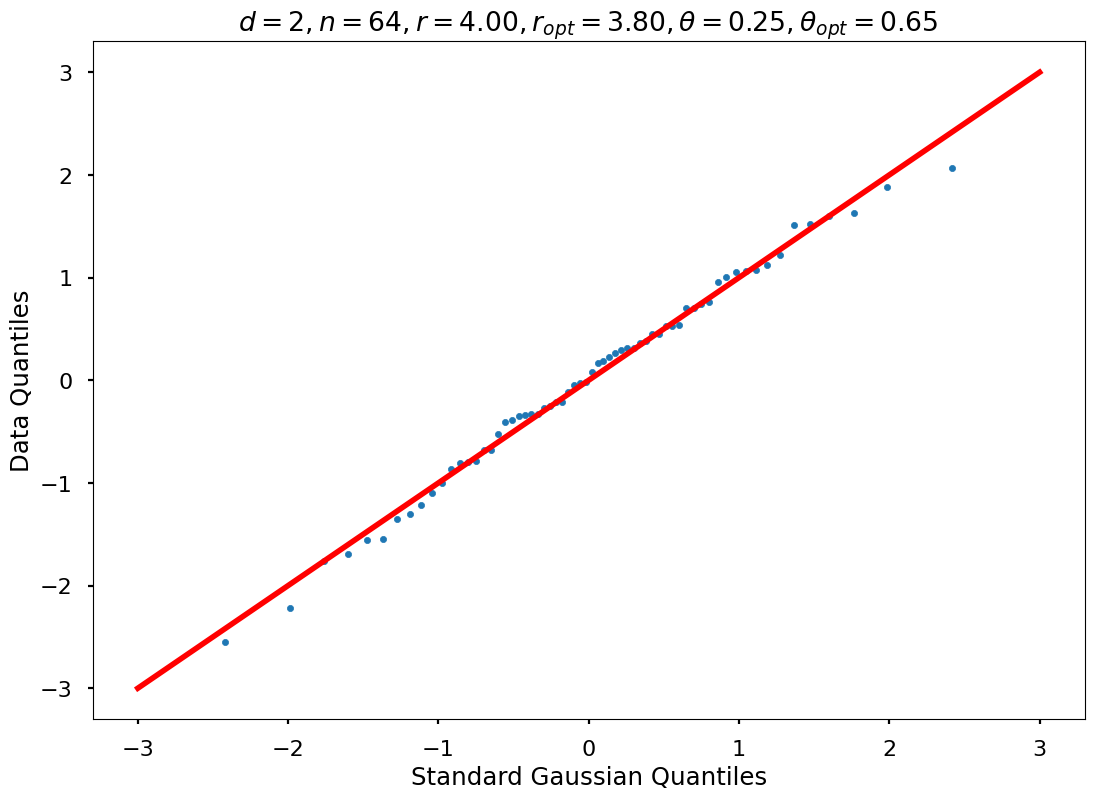

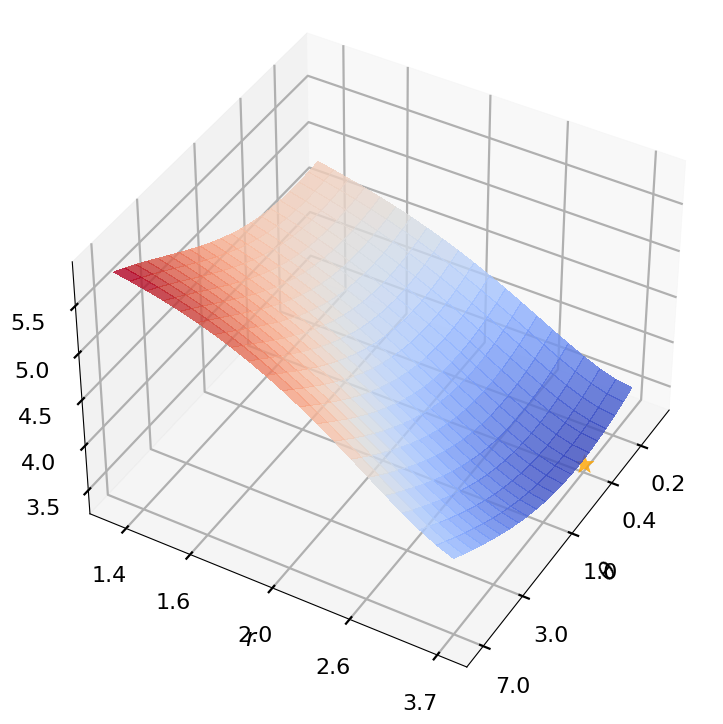

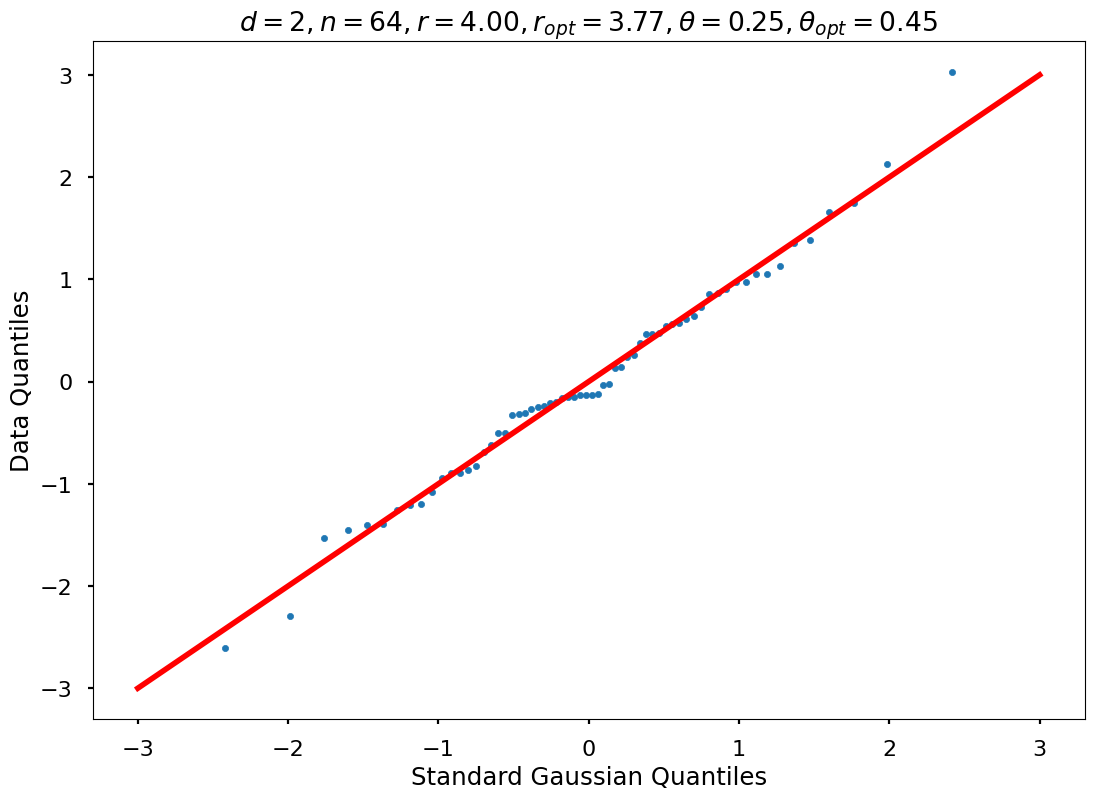

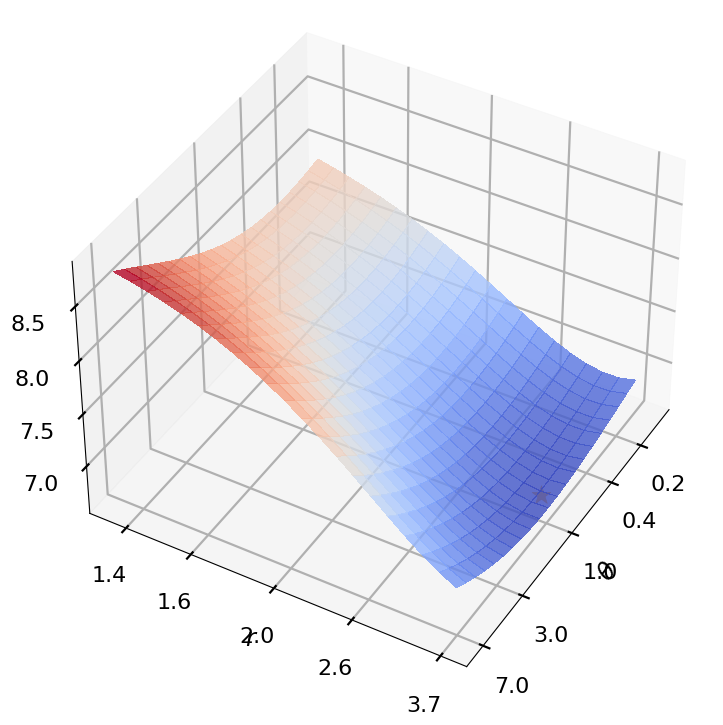

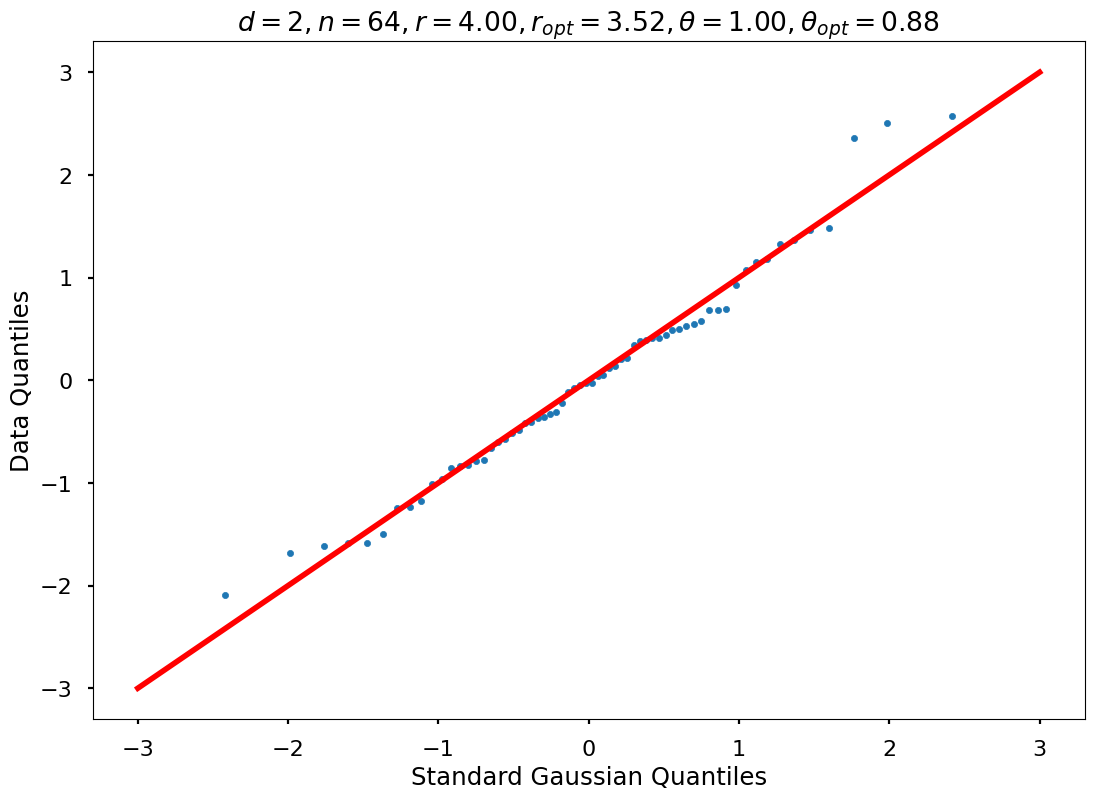

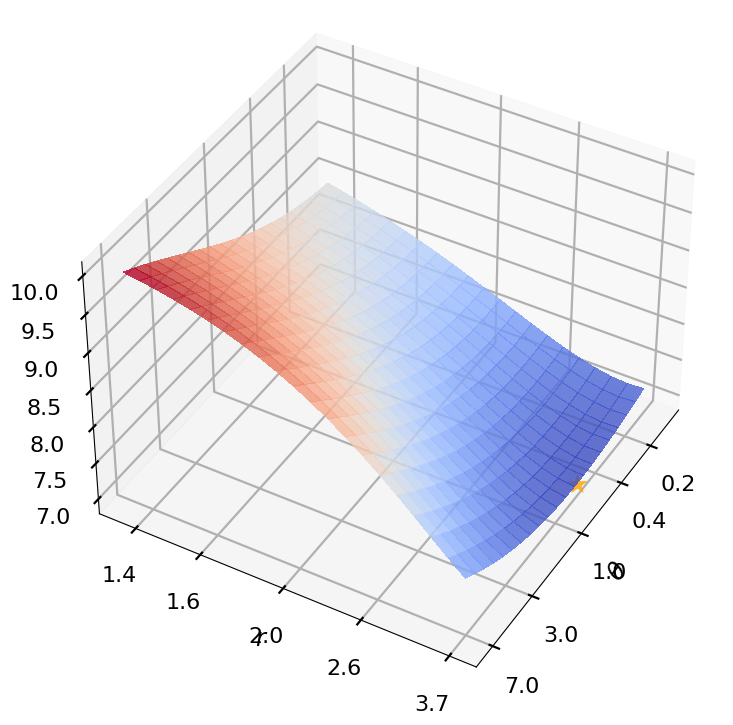

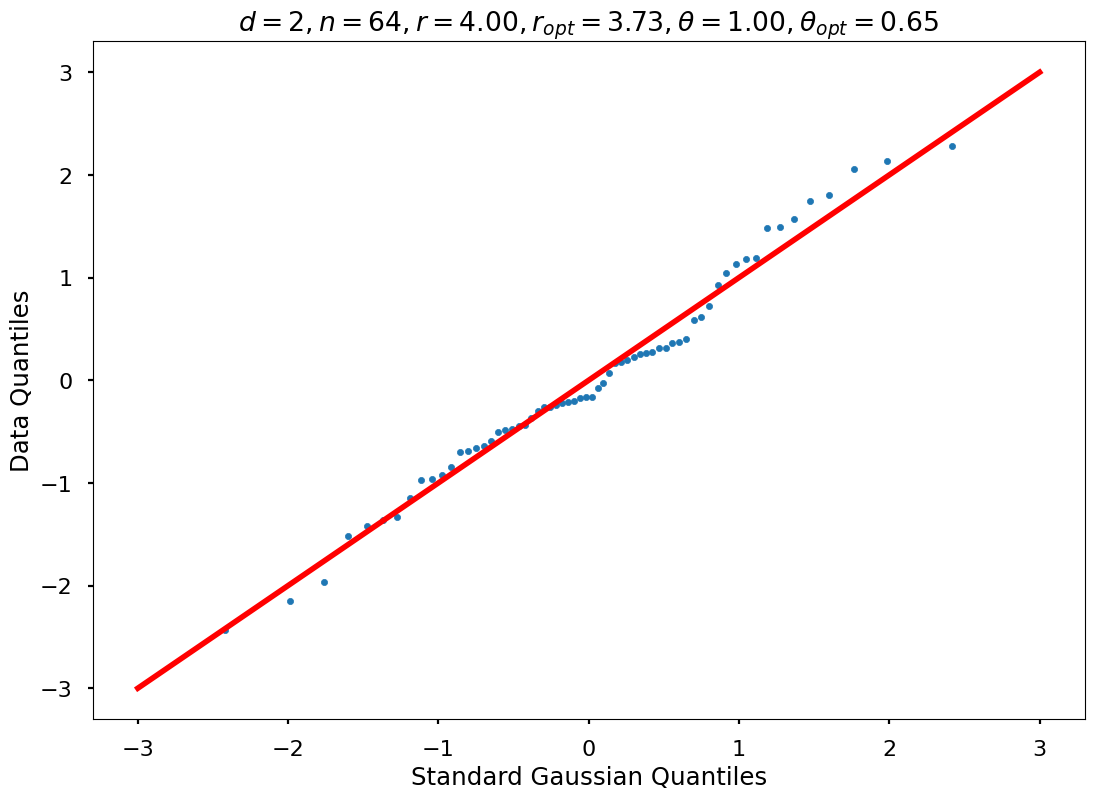

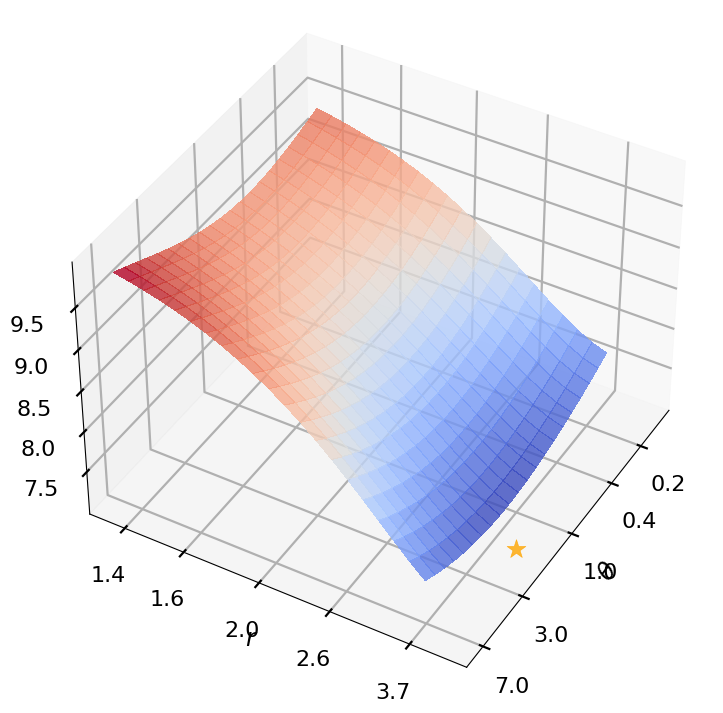

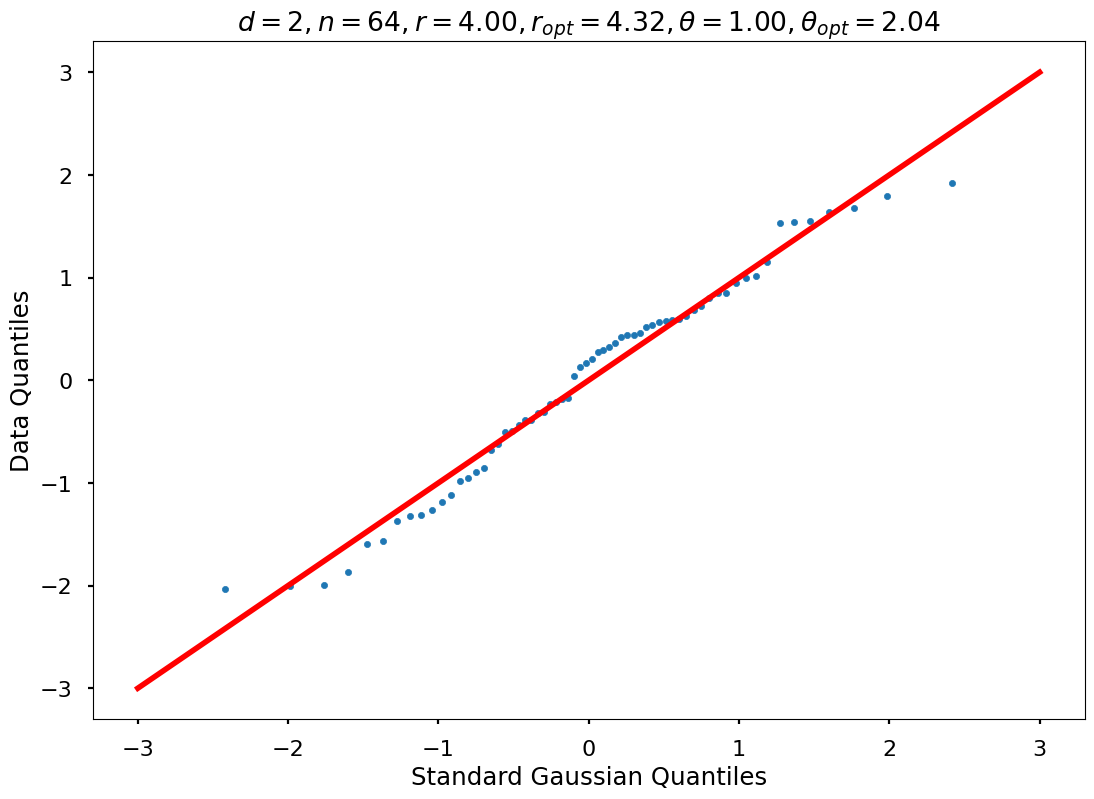

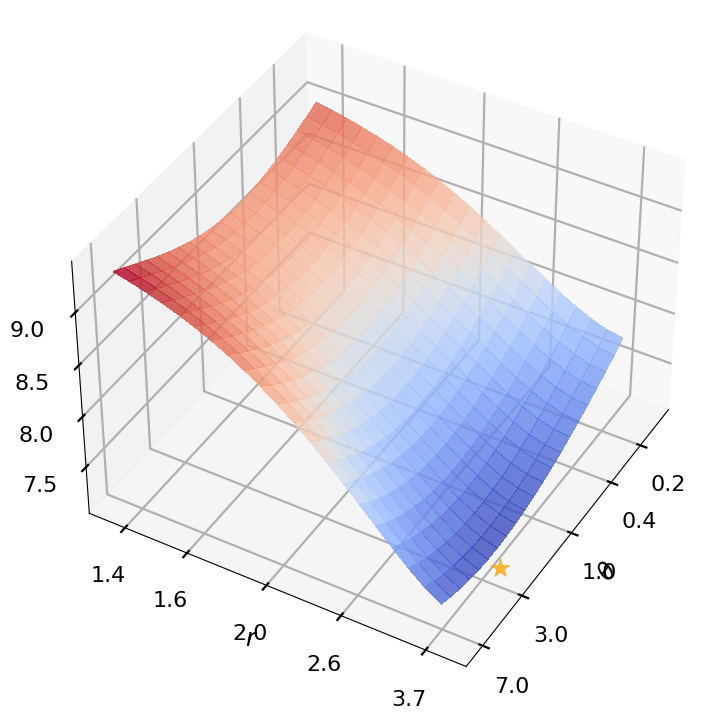

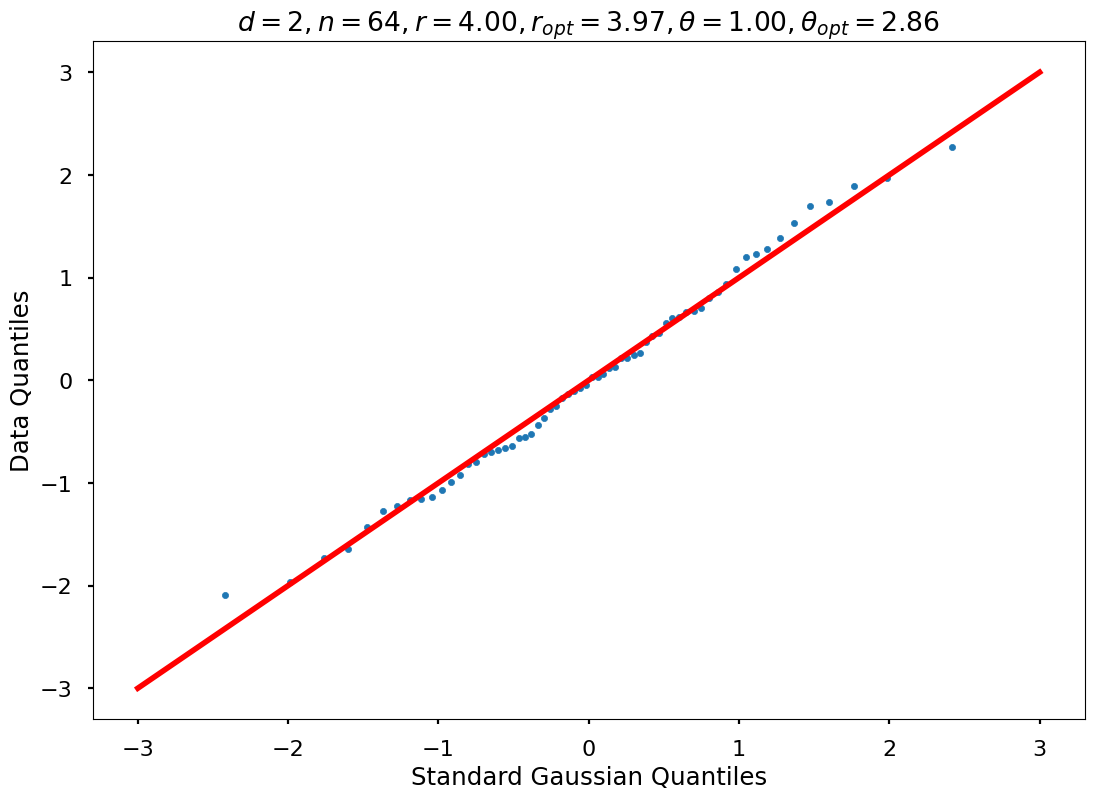

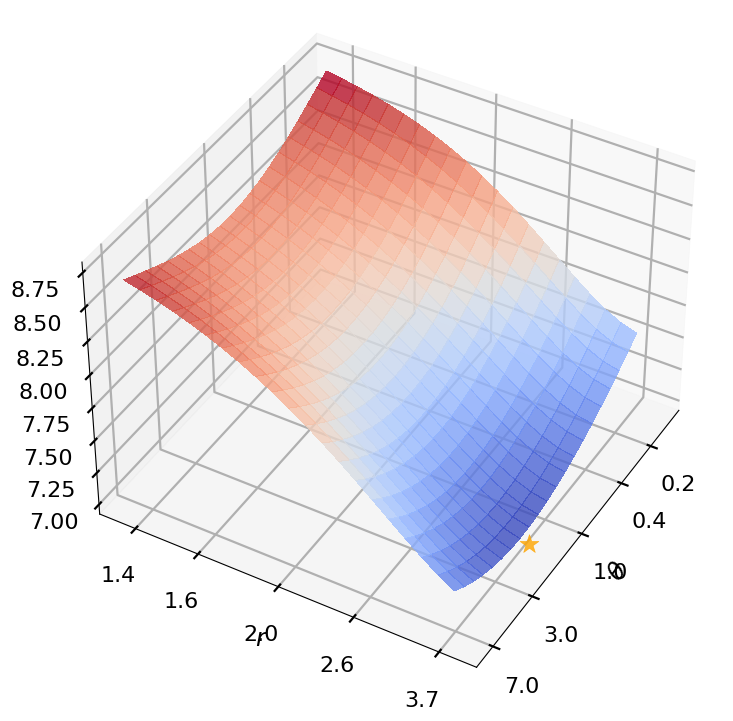

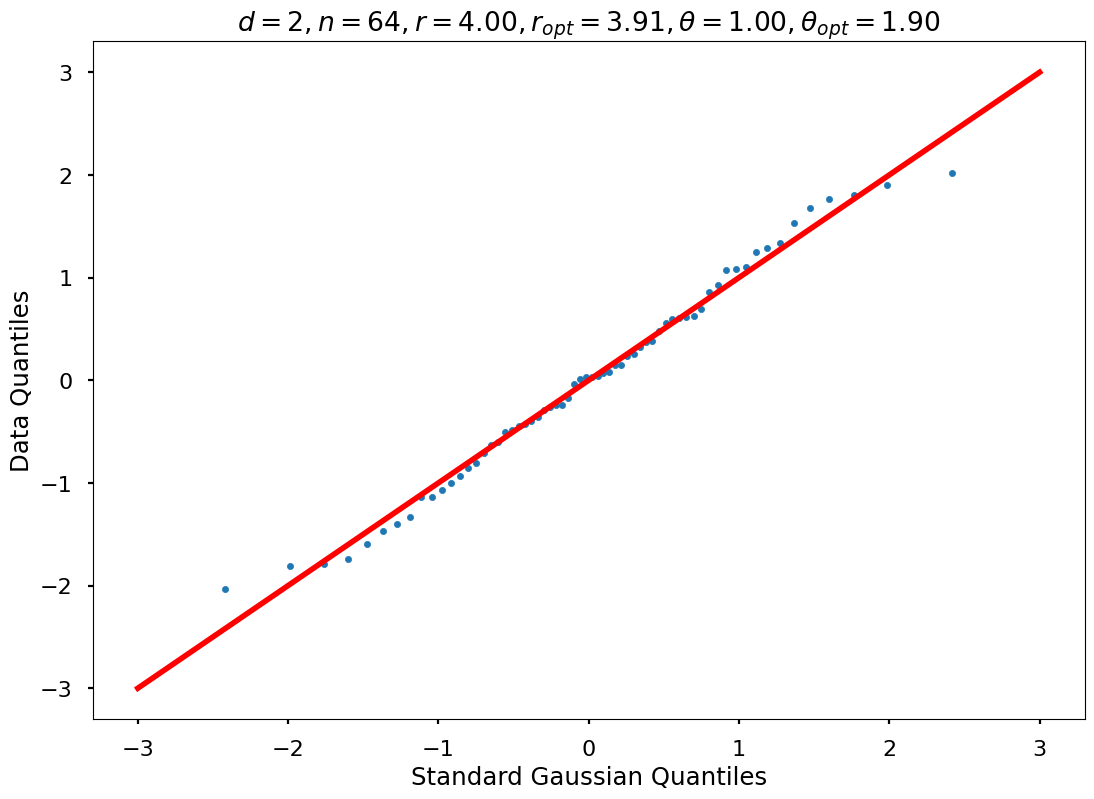

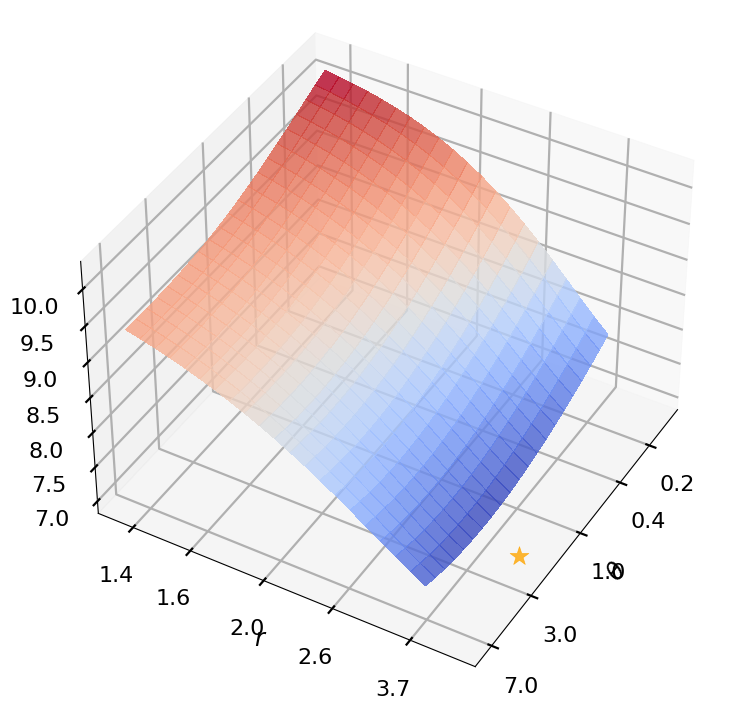

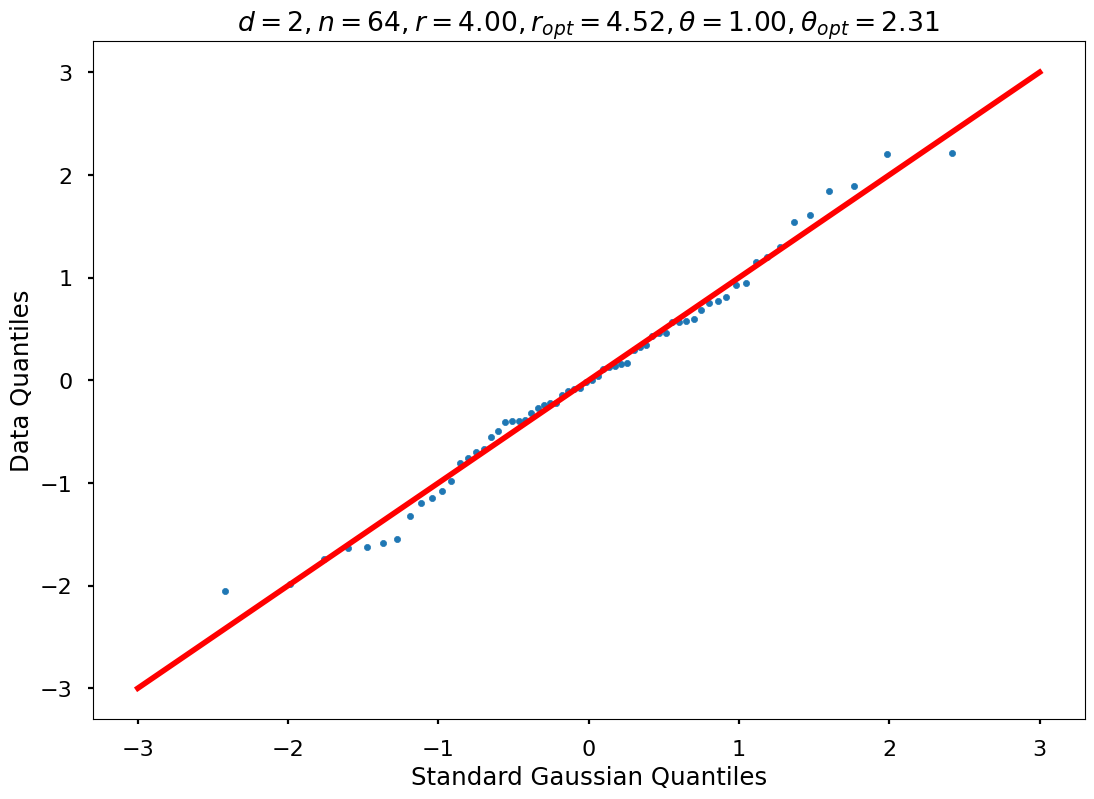

In [13]:
## Tests with random function
rArray = [1.5, 2, 4]
nrArr = len(rArray)
fParArray = [[0.5, 1, 2], [1, 1, 1], [1, 1, 1]]
nfPArr = len(fParArray)
fwh = 3
dim = 2
npts = 2 ** 6
nRep = 5  # reduced from 20 to reduce the plots
nPlot = 2
thetaAll = np.zeros((nrArr, nfPArr))
rOptAll = np.zeros((nrArr, nfPArr, nRep))
thOptAll = np.zeros((nrArr, nfPArr, nRep))
for jjj in range(nrArr):
    for kkk in range(nfPArr):
        thetaAll[jjj, kkk], rOptAll[jjj, kkk, :], thOptAll[jjj, kkk, :], fName = \
            gaussian_diagnostics_engine(fwh, dim, npts, rArray[jjj], fParArray[kkk], nRep, nPlot)


In [14]:
# close all the previous plots to freeup memory
plt.close('all')

### Plot additional figures for random function

[(1.0, 6.0), (0.01, 100.0)]

Text(0.5, 1.0, '$d = 2, n = 64$')

Text(0.5, 0, 'Inferred $r$')

Text(0, 0.5, 'Inferred $\\theta$')

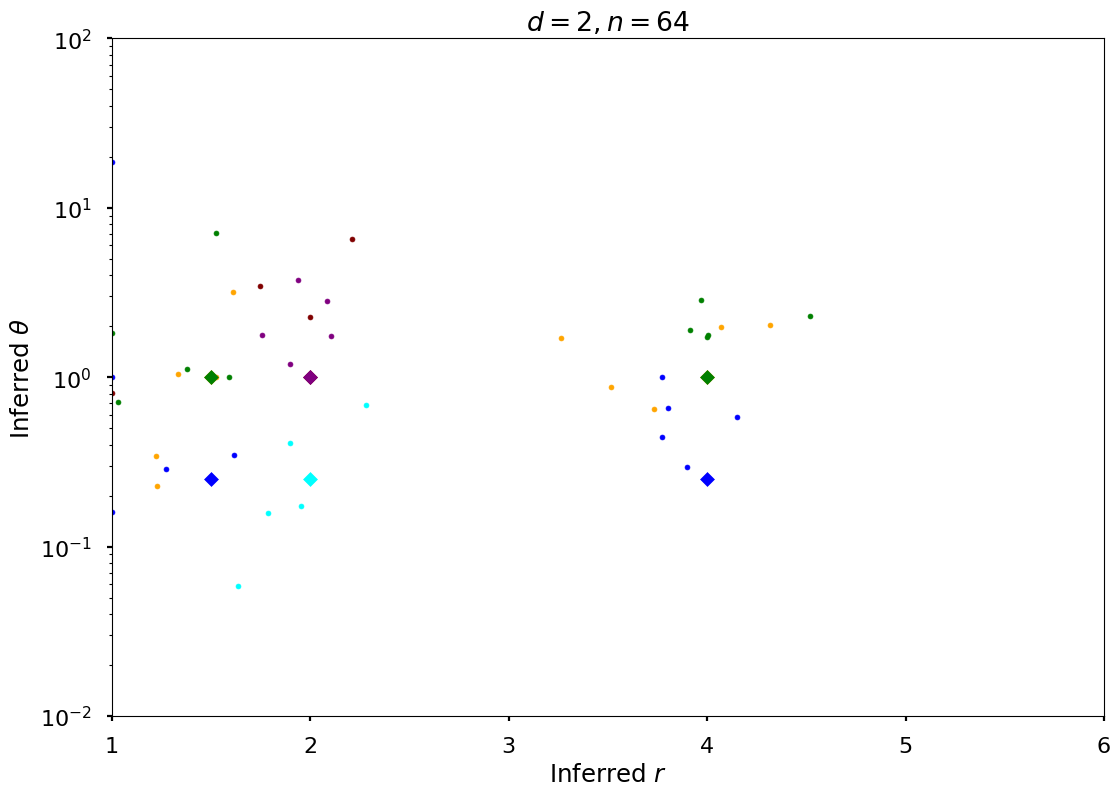

In [15]:
figH, axH = plt.subplots()
colorArray = ['blue', 'orange', 'green', 'cyan', 'maroon', 'purple']
nColArray = len(colorArray)
for jjj in range(nrArr):
    for kkk in range(nfPArr):
        clrInd = np.mod(nfPArr * (jjj) + kkk, nColArray)
        clr = colorArray[clrInd]
        axH.scatter(rOptAll[jjj, kkk, :].reshape((nRep, 1)), thOptAll[jjj, kkk, :].reshape((nRep, 1)),
                 s=50, c=clr, marker='.')
        axH.scatter(rArray[jjj], thetaAll[jjj, kkk], s=50, c=clr, marker='D')

axH.set(xlim=[1, 6], ylim=[0.01, 100])
axH.set_yscale('log')
axH.set_title(f'$d = {dim}, n = {npts}$')
axH.set_xlabel('Inferred $r$')
axH.set_ylabel('Inferred $\\theta$')
figH.savefig(f'{fName}-rthInfer-n-{npts}-d-{dim}.jpg')

In [16]:
# close all the previous plots to freeup memory
plt.close('all')

## Example 3a: Keister integrand: npts = 64

In [17]:
## Keister example
fwh = 2
dim = 3
npts = 2 ** 6
nRep = 20
nPlot = 2
_, rOptAll, thOptAll, fName = gaussian_diagnostics_engine(fwh, dim, npts, None, None, nRep, nPlot)

## Plot Keister example
figH = plt.figure()
plt.scatter(rOptAll, thOptAll, s=20, color='blue')
# axis([4 6 0.5 1.5])
# set(gca,'yscale','log')
plt.xlabel('Inferred $r$')
plt.ylabel('Inferred $\\theta$')
plt.title(f'$d = {dim}, n = {npts}$')
figH.savefig(f'{fName}-rthInfer-n-{npts}-d-{dim}.jpg')


ValueError: setting an array element with a sequence.

## Example 3b: Keister integrand: npts = 1024

10.596244143639485
7.142978946028139
r = None, rOpt = 7.18724, theta = None, thetaOpt = 0.71553

10.594856691086207
7.096409091118618
r = None, rOpt = 7.26586, theta = None, thetaOpt = 0.76520

10.591375134255042
7.0166323209172194
r = None, rOpt = 7.34554, theta = None, thetaOpt = 0.74504

10.595755571171377
7.067858016018031
r = None, rOpt = 7.34121, theta = None, thetaOpt = 0.75696

10.595982354998483
7.1228385587643395
r = None, rOpt = 7.22718, theta = None, thetaOpt = 0.70060

10.596298140666004
7.104717917027118
r = None, rOpt = 7.27766, theta = None, thetaOpt = 0.71703

10.592187612685716
7.0859774608781745
r = None, rOpt = 7.26092, theta = None, thetaOpt = 0.75369

10.596120527059021
7.10600296848717
r = None, rOpt = 7.25766, theta = None, thetaOpt = 0.69220

10.594256056513693
7.105374164104877
r = None, rOpt = 7.25124, theta = None, thetaOpt = 0.73247

10.596614398709978
7.137622143665308
r = None, rOpt = 7.20010, theta = None, thetaOpt = 0.70688

10.598230772383527
7.1868526

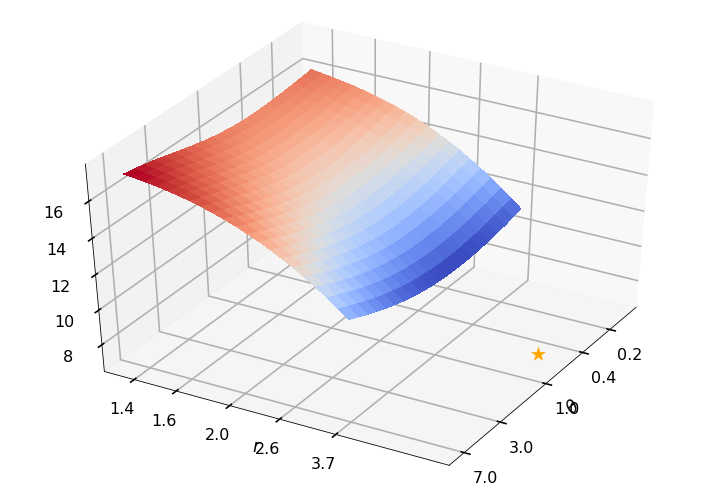

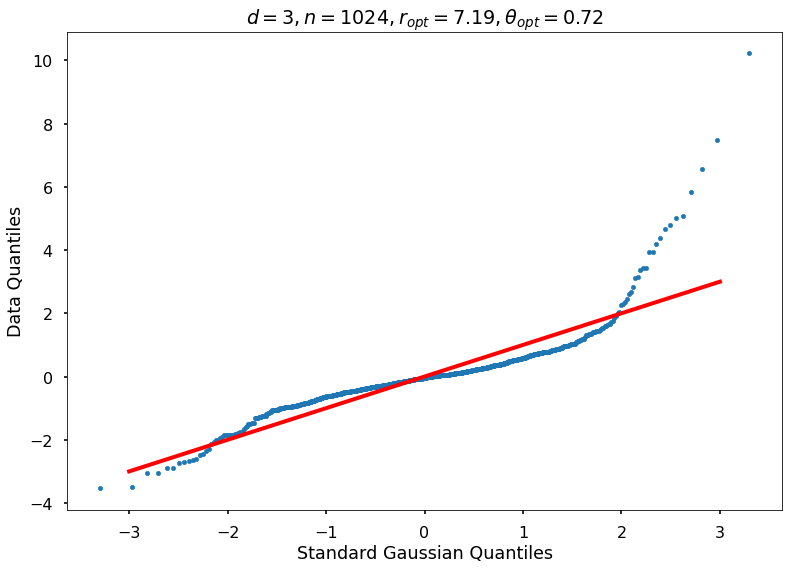

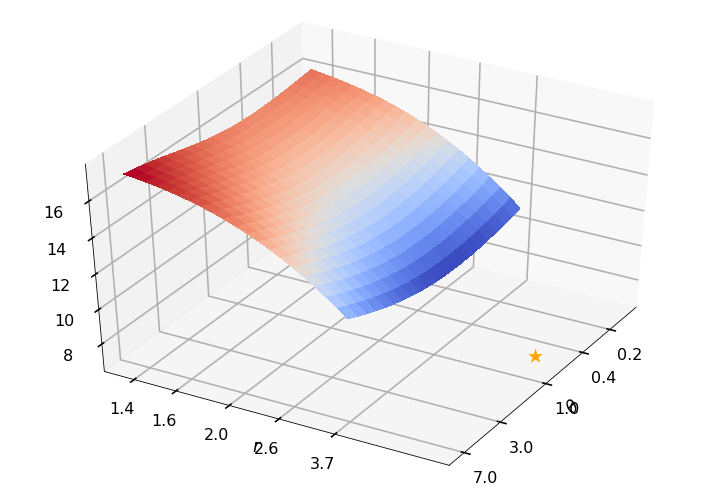

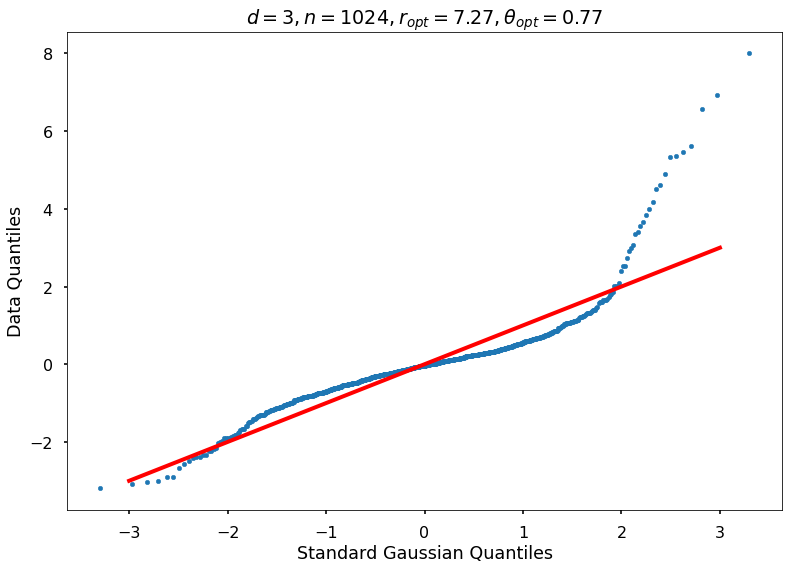

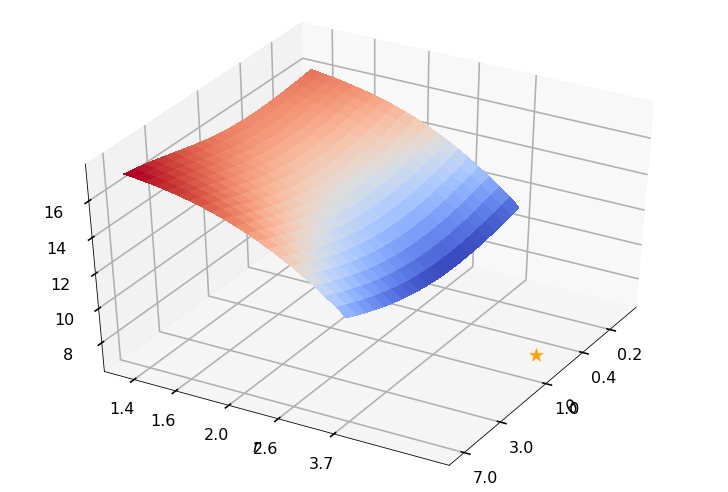

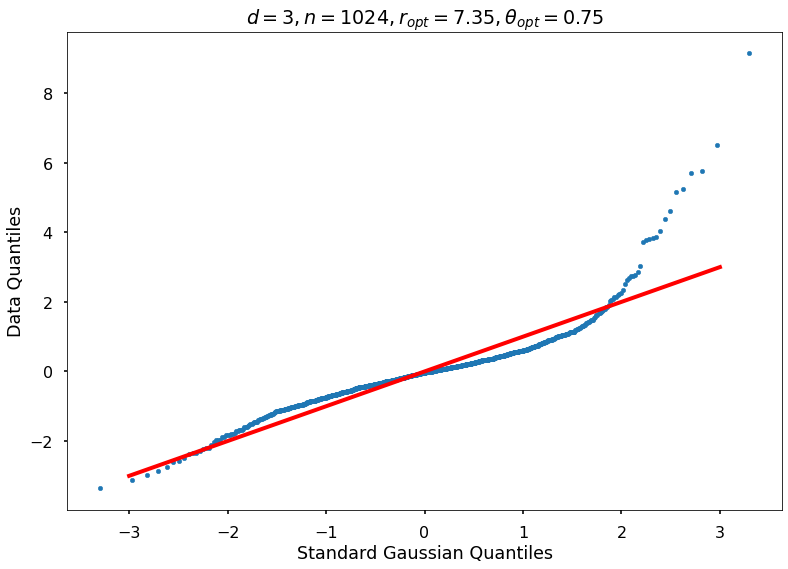

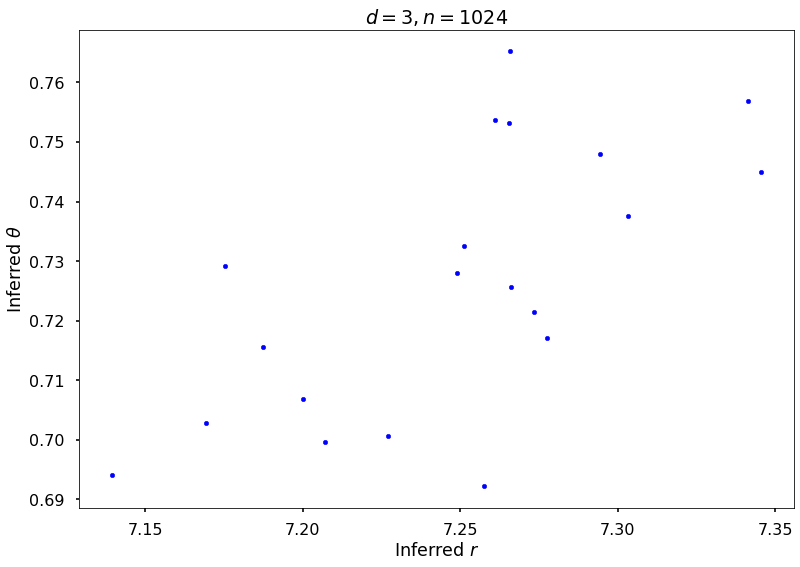

In [ ]:
## Keister example
fwh = 2
dim = 3
npts = 2 ** 10
nRep = 20
nPlot = 2
_, rOptAll, thOptAll, fName = gaussian_diagnostics_engine(fwh, dim, npts, None, None, nRep, nPlot)

## Plot Keister example
figH = plt.figure()
plt.scatter(rOptAll, thOptAll, s=20, color='blue')
# axis([4 6 0.5 1.5])
# set(gca,'yscale','log')
plt.xlabel('Inferred $r$')
plt.ylabel('Inferred $\\theta$')
plt.title(f'$d = {dim}, n = {npts}$')
figH.savefig(f'{fName}-rthInfer-n-{npts}-d-{dim}.jpg')